# ВЫПУСКНОЙ ПРОЕКТ "Модель предсказания оттока клиентов телекоммуникационной компании"


**ЦЕЛЬ ПРОЕКТА :** 
создать модель, которая будет предстазывать, разорвет ли клиент договор с оператором.

Для создания такой модели необходимо будет решить ряд задач.

**ЗАДАЧИ ПРОЕКТА :**
1. Загрузка данных. Необходимо загрузить данные и провести первичный осмотр данных, на базе полученной информации описать проблемы, которые необходимо будет решить в редобработке данных.
2. Предобработка данных. Провести "чистку" данных для дальнейшей работы.
3. Исследовательский анализ данных. Провести данный анализ и сделать вывод о данных.
4. Объединение данных. Выполнить по ключу в один датафрейм.
5. Исследовательский анализ и корреляционный анализ. Сделать портреть клиентов, которые пользуются оператором и нет. Провести корреляционный анализ.
6. Подготовка данных. Провести для данных для дальнейшего обучения.
7. Обучение моделей машинного обучения. Провести на трёх моделях, к каждой модели провести подбор гиперпараметров, построить для них метрики. ROC-AUC >= 0.85. Выбрать лучшую модель.
8. Исследование модели. Провести анализ, выбранной модели.
9. Итоговый вывод. Подвести итоги по проделанный работе.

**ОПИСАНИЕ ДАННЫХ**

Данные состоят из нескольких файлов, полученных из разных источников:
1. contract_new.csv — информация о договоре;
2. personal_new.csv — персональные данные клиента;
3. internet_new.csv — информация об интернет-услугах;
4. phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
!pip -q install phik

In [3]:
!pip3 install catboost -q

In [4]:
!pip install tabulate

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
from tabulate import tabulate

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,  RobustScaler, OrdinalEncoder ,PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from phik import phik_matrix

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
RANDOM_STATE = 28072025
TEST_SIZE = 0.25

##  ШАГ. ЗАГРУЗКА ДАННЫХ.
На начальном этапе работы с данными необходимо провести загрузку данных из предоставленных файлов и посмотреть общую информацию по данным файлам. После просмотра сделать соответствующие выводы, касаемо преобработки данных.

In [10]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
except:
    contract = pd.read_csv('http://code.s3.yandex.net/datasets/contract_new.csv')


In [11]:
display(contract.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [12]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [13]:
try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except:
    personal = pd.read_csv('http://code.s3.yandex.net/datasets/personal_new.csv')

In [14]:
display(personal.head(5))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except:
    internet = pd.read_csv('http://code.s3.yandex.net/datasets/internet_new.csv')

In [17]:
display(internet.head(5))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    phone = pd.read_csv('http://code.s3.yandex.net/datasets/phone_new.csv')

In [20]:
display(phone.head(5))

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [21]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### ВЫВОД:

После загрузки данных и первичного просмотра файла было установлено, что:

- для файла contract_new.csv необходимо:
  - изменить названия колонн (перейти на нижний регистр и поставить знак "_" вместо пробела)
  - поменять тип данных для BeginDate, TotalCharges
  - проверить на наличие пропусков и дубликатов в данных, если есть возможность - поставить заглушки.
  - проверить на уникальность категорических признаков для данных EndDate, Type, PaperlessBilling и PaymentMethod. Если будет выдавать ошибки - исправить их.

- для файла personal_new.csv необходимо:
  - изменить названия колонн (перейти на нижний регистр и поставить знак "_" вместо пробела)
  - проверить на уникальность категорических признаков, если будет выдавать ошибки - исправить их.
  - проверить на наличие пропусков и дубликатов в данных, если есть возможность - поставить заглушки.
  
- для файла internet_new.csv необходимо:
  - изменить названия колонн (перейти на нижний регистр и поставить знак "_" вместо пробела)
  - проверить на уникальность категорических признаков, если будет выдавать ошибки - исправить их.
  - проверить на наличие пропусков и дубликатов в данных, если есть возможность - поставить заглушки.
  
- для файла phone_new.csv необходимо:
  - изменить названия колонн (перейти на нижний регистр и поставить знак "_" вместо пробела)
  - проверить на уникальность категорических признаков, если будет выдавать ошибки - исправить их.
  - проверить на наличие пропусков и дубликатов в данных, если есть возможность - поставить заглушки.

## ШАГ. ПРЕДОБРАБОТКА ДАННЫХ.

На данном этапе необходимо провести предобработку данных всех файлов по тем пунктам, которые были представленны в выводе по шагу 1.

### предобработка данных contract

In [22]:
contract.set_axis(['customer_ID', 'Begin_Date', 'End_Date', 'Type', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charges', 'Total_Charges'], axis="columns", inplace=True) 
contract.columns = contract.columns.str.lower()

In [23]:
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [24]:
print(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


In [25]:
print('Количество дубликотов строк в contract:',contract.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(contract.duplicated().sum() / contract.shape[0]* 100,3))
print('Количество строк:',contract.shape[0])

Количество дубликотов строк в contract: 0
Процент дубликатов строк от всего количества строк: 0.0
Количество строк: 7043


In [26]:
contract_id = contract.set_index('customer_id')
print('Количество дубликотов строк в contract без id:',contract_id.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(contract_id.duplicated().sum() / contract_id.shape[0]* 100,3))

Количество дубликотов строк в contract без id: 37
Процент дубликатов строк от всего количества строк: 0.525


In [27]:
print(contract.isna().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


In [28]:
list = ['begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'total_charges']

for word in list:
    print(f'уникальные значения столбца {word}: {contract[word].unique()}\n')

уникальные значения столбца begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-

In [29]:
list = ['type', 'paperless_billing', 'payment_method']

for word in list:
    if word == 'payment_method':
        contract[word] = contract[word].replace('Bank transfer (automatic)' ,'Bank transfer').replace('Credit card (automatic)' ,'Credit card')
    
    contract[word] = contract[word].str.replace(' ','_').str.lower()
    print(f'уникальные значения столбца {word}: {contract[word].unique()}\n')

уникальные значения столбца type: ['month-to-month' 'one_year' 'two_year']

уникальные значения столбца paperless_billing: ['yes' 'no']

уникальные значения столбца payment_method: ['electronic_check' 'mailed_check' 'bank_transfer' 'credit_card']



In [30]:
print('Количество клиентов, у которых общих расходов нет:', contract.query('total_charges == 0')['customer_id'].count())

Количество клиентов, у которых общих расходов нет: 0


In [31]:
print('Количество клиентов, у которых не указаны общие расходы:', contract.query('total_charges == " "')['customer_id'].count())

Количество клиентов, у которых не указаны общие расходы: 11


In [32]:
display(contract.query('total_charges == " "').head(11))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,two_year,yes,bank_transfer,52.55,
753,3115-CZMZD,2020-02-01,No,two_year,no,mailed_check,20.25,
936,5709-LVOEQ,2020-02-01,No,two_year,no,mailed_check,80.85,
1082,4367-NUYAO,2020-02-01,No,two_year,no,mailed_check,25.75,
1340,1371-DWPAZ,2020-02-01,No,two_year,no,credit_card,56.05,
3331,7644-OMVMY,2020-02-01,No,two_year,no,mailed_check,19.85,
3826,3213-VVOLG,2020-02-01,No,two_year,no,mailed_check,25.35,
4380,2520-SGTTA,2020-02-01,No,two_year,no,mailed_check,20.00,
5218,2923-ARZLG,2020-02-01,No,one_year,yes,mailed_check,19.70,
6670,4075-WKNIU,2020-02-01,No,two_year,no,mailed_check,73.35,


In [33]:
contract['total_charges'] = contract['total_charges'].str.replace(' ','0').astype('float')

In [34]:
display(contract.query('end_date == "No"').head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,month-to-month,yes,electronic_check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,one_year,no,mailed_check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,month-to-month,yes,mailed_check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,one_year,no,bank_transfer,42.30,1960.60
4,9237-HQITU,2019-09-01,No,month-to-month,yes,electronic_check,70.70,353.50


! Проверка на наличие клиентов, у которых заканчивается договор 2020-02-01

In [35]:
display(contract.query('end_date == "2020-02-01"').head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


In [36]:
print('Количество клиентов, у которых прекращается договор на 01.02.2020:', contract.query('end_date == "2020-02-01"')['customer_id'].count())

Количество клиентов, у которых прекращается договор на 01.02.2020: 0


In [37]:
print('Количество клиентов, у которых действующий договор на 01.02.2020:', contract.query('end_date == "No"')['customer_id'].count())

Количество клиентов, у которых действующий договор на 01.02.2020: 5942


In [38]:
print(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


#### ВЫВОД:

Была совершена преобработка данных contract.
Было сделано:
- преведены в нижнему регистру и разделены знаком "_" названия колонн.
- проверено на наличие дубликатов. Дубликаты явные дубликаты отсутствуют. Также была проведена проверка на дубликаты без учёта id, их оказалось 37, что составляет 0.5% от всех данных. Было принято решение их не удалять.
- в данных отсутсвуют пропуски
- были исследованы на уникальность значений категорические признаки. Они были приведены к нижнему регистру, запись через знак "_", также сокращение их написания, для облегчения восприятия информации.
- в данных total_charges на " " была поставлена заглужка 0,поскольку эти клиенты оформились 2020-02-01(данные рассматриваются по отношению к этой дате, поэтому общий расход 0), данные были приведены к типу float
- в данных end_date на "No" в дальнейшем будет поставлена заглужка "2020-02-01", поскольку даные актуальны до 01.02.2020. Всего клиентов, у которых не истек срок действия контракта составляет 5942. Но это справедливо для данного набора данных, для других данных может быть так, что заглушка будет перекликаться со значениями. Было принято решение поставить заглушку после этапа объединения данных.
- данные befin_date и end_date были приведены к типу datetime.
- возможно в данных с датами в дальнейшем будут выделены столбцы по годам.


### предобработка данных personal

In [39]:
personal.set_axis(['customer_ID', 'gender', 'Senior_Citizen', 'Partner', 'Dependents'], axis="columns", inplace=True) 
personal.columns = personal.columns.str.lower()

In [40]:
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [41]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [42]:
print('Количество дубликотов строк в personal:',personal.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(personal.duplicated().sum() / personal.shape[0]* 100,3))
print('Количество строк:',personal.shape[0])

Количество дубликотов строк в personal: 0
Процент дубликатов строк от всего количества строк: 0.0
Количество строк: 7043


In [43]:
personal_id = personal.set_index('customer_id')
print('Количество дубликотов строк в internet без id:',personal_id.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(personal_id.duplicated().sum() / personal_id.shape[0]* 100,3))

Количество дубликотов строк в internet без id: 7027
Процент дубликатов строк от всего количества строк: 99.773


In [44]:
print(personal.isna().sum())

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


In [45]:
list = ['gender', 'senior_citizen', 'partner', 'dependents']

for word in list:
    print(f'уникальные значения столбца {word}: {personal[word].unique()}\n')

уникальные значения столбца gender: ['Female' 'Male']

уникальные значения столбца senior_citizen: [0 1]

уникальные значения столбца partner: ['Yes' 'No']

уникальные значения столбца dependents: ['No' 'Yes']



In [46]:
list = ['gender', 'senior_citizen', 'partner', 'dependents']

for word in list:
    if word == 'senior_citizen':
        personal[word] = personal[word].astype('str')
        personal[word] = personal[word].str.replace('1','yes').str.replace('0','no')
        
    personal[word] = personal[word].str.lower()   
    
    print(f'уникальные значения столбца {word}: {personal[word].unique()}\n')

уникальные значения столбца gender: ['female' 'male']

уникальные значения столбца senior_citizen: ['no' 'yes']

уникальные значения столбца partner: ['yes' 'no']

уникальные значения столбца dependents: ['no' 'yes']



#### ВЫВОД:

Была совершена преобработка данных personal.

Было сделано:
- преведены в нижнему регистру и разделены знаком "_" названия колонн.
- проверено на наличие дубликатов. Дубликаты явные дубликаты отсутствуют. Также была проведена проверка на дубликаты без учёта id, их оказалось 7027, что составляет 99.8% от всех данных. Было принято решение их не удалять.
- в данных отсутсвуют пропуски
- были исследованы на уникальность значений категорические признаки. Они были приведены к нижнему регистру.
- был изменен тип данных "senior_citizen" на str (приведение к категорическим признакам) и замена на 'yes' и 'no' данных со значениями 1 и 0 соответвенно.

### предобработка данных internet

In [47]:
internet.set_axis(['customer_ID', 'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies'], axis="columns", inplace=True) 
internet.columns = internet.columns.str.lower()

In [48]:
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [49]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [50]:
print('Количество дубликотов строк в internet:',internet.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(internet.duplicated().sum() / internet.shape[0]* 100,3))
print('Количество строк:',internet.shape[0])

Количество дубликотов строк в internet: 0
Процент дубликатов строк от всего количества строк: 0.0
Количество строк: 5517


In [51]:
internet_id = internet.set_index('customer_id')
print('Количество дубликотов строк в internet без id:',internet_id.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(internet_id.duplicated().sum() / internet_id.shape[0]* 100,3))

Количество дубликотов строк в internet без id: 5389
Процент дубликатов строк от всего количества строк: 97.68


In [52]:
print(internet.isna().sum())

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


In [53]:
list = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']

for word in list:
    print(f'уникальные значения столбца {word}: {internet[word].unique()}\n')

уникальные значения столбца internet_service: ['DSL' 'Fiber optic']

уникальные значения столбца online_security: ['No' 'Yes']

уникальные значения столбца online_backup: ['Yes' 'No']

уникальные значения столбца device_protection: ['No' 'Yes']

уникальные значения столбца tech_support: ['No' 'Yes']

уникальные значения столбца streaming_tv: ['No' 'Yes']

уникальные значения столбца streaming_movies: ['No' 'Yes']



In [54]:
list = ['internet_service','online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']

for word in list:
    if word == 'internet_service':
        internet[word] = internet[word].str.replace(' ','_').str.lower()
        
    internet[word] = internet[word].str.lower()   
    
    print(f'уникальные значения столбца {word}: {internet[word].unique()}\n')

уникальные значения столбца internet_service: ['dsl' 'fiber_optic']

уникальные значения столбца online_security: ['no' 'yes']

уникальные значения столбца online_backup: ['yes' 'no']

уникальные значения столбца device_protection: ['no' 'yes']

уникальные значения столбца tech_support: ['no' 'yes']

уникальные значения столбца streaming_tv: ['no' 'yes']

уникальные значения столбца streaming_movies: ['no' 'yes']



#### ВЫВОД:

Была совершена преобработка данных internet.
Было сделано:
- преведены в нижнему регистру и разделены знаком "_" названия колонн.
- проверено на наличие дубликатов. Дубликаты явные дубликаты отсутствуют. Также была проведена проверка на дубликаты без учёта id, их оказалось 5389, что составляет 98% от всех данных. Было принято решение их не удалять.
- в данных отсутсвуют пропуски
- были исследованы на уникальность значений категорические признаки. Они были приведены к нижнему регистру, запись через знак "_".

### преобоработка данных phone

In [55]:
phone.set_axis(['customer_ID', 'Multiple_Lines'], axis="columns", inplace=True) 
phone.columns = phone.columns.str.lower()

In [56]:
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [57]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [58]:
print('Количество дубликотов строк в phone:',phone.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(phone.duplicated().sum() / phone.shape[0]* 100,3))
print('Количество строк:',phone.shape[0])

Количество дубликотов строк в phone: 0
Процент дубликатов строк от всего количества строк: 0.0
Количество строк: 6361


In [59]:
print(phone.isna().sum())

customer_id       0
multiple_lines    0
dtype: int64


In [60]:
print('уникальные значения столбца multiple_lines: ',phone['multiple_lines'].unique())

уникальные значения столбца multiple_lines:  ['No' 'Yes']


In [61]:
phone['multiple_lines'] = phone['multiple_lines'].str.lower()
print('уникальные значения столбца multiple_lines: ',phone['multiple_lines'].unique())

уникальные значения столбца multiple_lines:  ['no' 'yes']


#### ВЫВОД:

Была совершена преобработка данных phone.
Было сделано:
- преведены в нижнему регистру и разделены знаком "_" названия колонн.
- проверено на наличие дубликатов. Дубликаты явные дубликаты отсутствуют.
- в данных отсутсвуют пропуски
- были исследованы на уникальность значений категорические признаки. Они были приведены к нижнему регистру.

### ВЫВОД:

Была проведена предобратобка данных contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv.

Во всех данных было сделано:
- преведены в нижнему регистру и разделены знаком "_" названия колонн.
- проверка на пропуски. Во всех данных они отсутствуют.
- проверка на явные дубликаты - отсутвуют. Но без учёта id в contract - 37 (что составляет 0.5% от данных), в personal-7027(99.8% от данных), в internet - 5389(98%).
- были исследованы на уникальность значений категорические признаки.  Они были приведены к нижнему регистру, запись через знак "_", также сокращение их написания, для облегчения восприятия информации.

В contract:
- в данных total_charges на " " была поставлена заглужка 0,поскольку эти клиенты оформились 2020-02-01(данные рассматриваются по отношению к этой дате, поэтому общий расход 0), данные были приведены к типу float
- в данных end_date на "No" в дальнейшем будет поставлена заглужка "2020-02-01", поскольку даные актуальны до 01.02.2020. Всего клиентов, у которых не истек срок действия контракта составляет 5942. Но это справедливо для данного набора данных, для других данных может быть так, что заглушка будет перекликаться со значениями. Было принято решение поставить заглушку после этапа объединения данных.
- данные befin_date и end_date были приведены к типу datetime.
- возможно в данных с датами в дальнейшем будут выделены столбцы по годам.

В personal:
- был изменен тип данных "senior_citizen" на str (приведение к категорическим признакам) и замена на 'yes' и 'no' данных со значениями 1 и 0 соответвенно.

## ШАГ. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

На данном этапе необходимо провести исследовательский анализ для каждого датафрейма и при необходимости выполнить предобработку. Также сделать выводы об имеющихся имеющихся признаках: понадобятся ли они для обучения моделей.

### исследовательский анализ данных contract

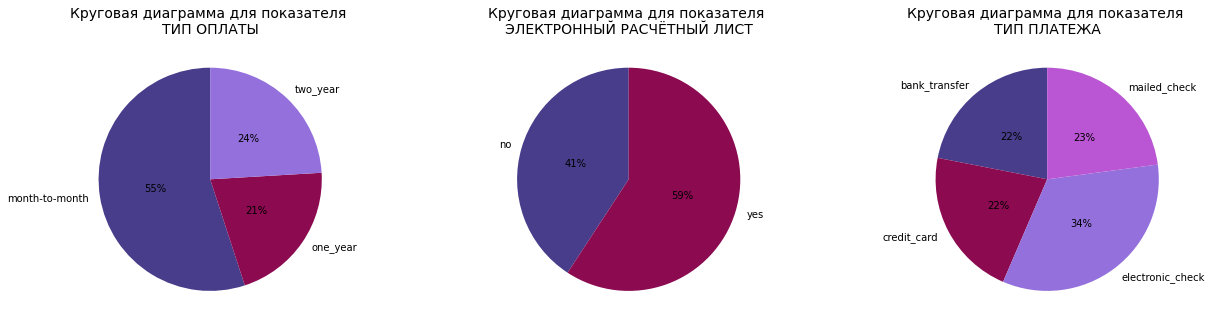

In [62]:
fig = plt.figure(figsize=(20,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['type','paperless_billing',  'payment_method']
list_1 = ['тип оплаты', 'электронный расчётный лист', 'тип платежа']

for i in range(3):
    name = list[c]
    name_1 = list_1[list.index(name)]
    ax1 = plt.subplot2grid((1,3), (r, c))
    df1 = contract.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
    labels = df1.reset_index()[name]
    plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
    plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}', fontsize=14);
    c += 1
    i+=1 

Абоненты предпочитают помесячную оплату(55%). Меньше всего (21%) клиентам нравится заключение договора на год.

Большая часть клиентов (59%) предпочитают электронный расчётный лист.

Самай распространённый тип платежа - это электронный чек(34%), второй по популярности метод платежа - чек на почту (23%), банковский перевод или кредитная карта расположились на 3-ем месте (22%).

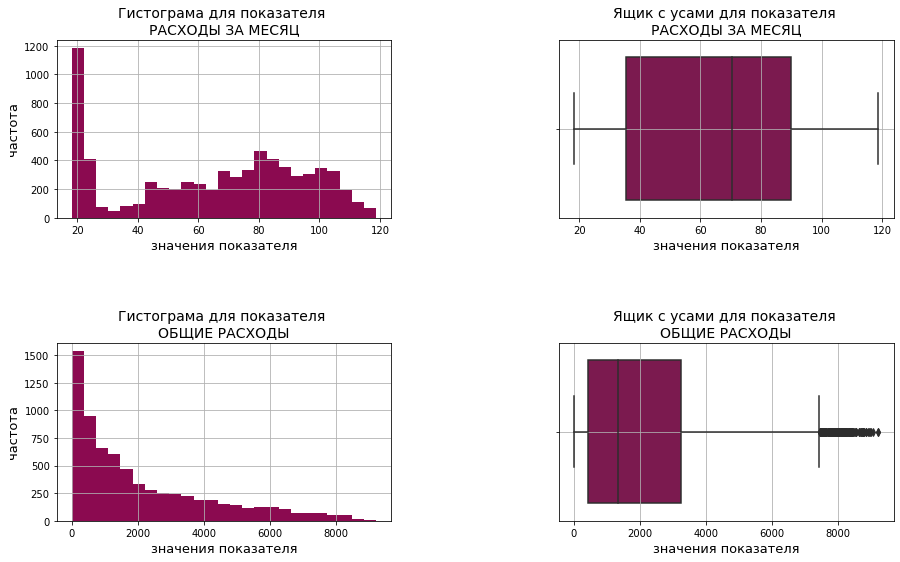

In [63]:
position = 0
plt.figure(figsize=[15,20])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = ['monthly_charges','total_charges']
list_1 = ['расходы за месяц', 'общие расходы']

for name in list:
    position += 1
    
    df1 = contract[name]
    name_1 = list_1[list.index(name)]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = '#8B0A50', bins = 25)
    plt.title(f'Гистограма для показателя \n{name_1.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = contract[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = '#8B0A50')
    plt.title(f'Ящик с усами для показателя \n{name_1.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [64]:
print(f'Характеристики количественных показателей данных')
display(contract.describe())

Характеристики количественных показателей данных


,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


Исследование количественных признаков показал, что:
- средний расход на месяц составляет 70.3, максимальный - 118, минимальный - 18.25. Пик значений в районе 20 характерен для клиентов, которые оформляют договор и сразу его закрывают.
- средний общий расход составляет 1343. Минимальный расход составляет 0 - это у тех клиентов, которые заключили договор 2020-02-01.

Далее в расходах за месяц наблюдается два пика. Первый пик приходится на интервал, приближительно, от 10 до 30. Интересно посмотреть, что там за значения, с чем может быть связано.

В общих расходах наблюдаются выбросы за 3236, необходимо посмотреть, что это за значения, с чём может быть такое связано.

In [65]:
display(contract.query('monthly_charges <21').head(10))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
11,7469-LKBCI,2018-10-01,No,two_year,no,credit_card,18.95,312.30
16,8191-XWSZG,2015-10-01,No,one_year,no,mailed_check,20.65,1106.01
21,1680-VDCWW,2019-02-01,No,one_year,no,bank_transfer,19.80,237.60
22,1066-JKSGK,2019-11-01,No,month-to-month,no,mailed_check,20.15,61.05
33,7310-EGVHZ,2020-01-01,No,month-to-month,no,bank_transfer,20.20,22.22
42,9867-JCZSP,2018-09-01,No,one_year,no,mailed_check,20.75,352.75
68,3170-NMYVV,2015-12-01,No,two_year,no,bank_transfer,20.15,1007.50
71,0731-EBJQB,2015-10-01,No,one_year,yes,electronic_check,20.40,1060.80
84,0318-ZOPWS,2016-01-01,No,two_year,yes,bank_transfer,20.15,987.35
87,1862-QRWPE,2016-02-01,No,two_year,no,bank_transfer,20.65,991.20


In [66]:
print('Количество клиентов, у которых расходы за месяц меньше 21:', contract.query('monthly_charges <21')['customer_id'].count())

Количество клиентов, у которых расходы за месяц меньше 21: 1159


In [67]:
print(contract.query('monthly_charges <21')['begin_date'].astype('str').unique())

['2018-10-01' '2015-10-01' '2019-02-01' '2019-11-01' '2020-01-01'
 '2018-09-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-04-01'
 '2014-02-01' '2016-09-01' '2019-08-01' '2019-10-01' '2014-10-01'
 '2015-05-01' '2018-04-01' '2019-03-01' '2014-05-01' '2017-06-01'
 '2015-01-01' '2019-01-01' '2015-03-01' '2017-09-01' '2019-04-01'
 '2015-02-01' '2014-03-01' '2017-03-01' '2019-06-01' '2014-11-01'
 '2014-04-01' '2019-09-01' '2016-03-01' '2017-05-01' '2018-07-01'
 '2018-03-01' '2018-06-01' '2019-12-01' '2017-02-01' '2016-06-01'
 '2018-11-01' '2015-07-01' '2014-09-01' '2014-08-01' '2019-05-01'
 '2017-01-01' '2015-09-01' '2020-02-01' '2018-12-01' '2014-06-01'
 '2017-12-01' '2016-10-01' '2017-11-01' '2017-04-01' '2018-05-01'
 '2016-08-01' '2018-01-01' '2015-08-01' '2018-08-01' '2019-07-01'
 '2017-07-01' '2017-10-01' '2016-11-01' '2014-07-01' '2015-04-01'
 '2015-06-01' '2017-08-01' '2016-12-01' '2015-11-01' '2016-05-01'
 '2018-02-01' '2014-12-01' '2016-07-01']


In [68]:
print(contract.query('monthly_charges <21')['end_date'].astype('str').unique())

['No' '2018-06-01' '2020-01-01' '2015-06-01' '2019-04-01' '2017-08-01'
 '2018-08-01' '2015-12-01' '2019-03-01' '2018-03-01' '2016-02-01'
 '2019-07-01' '2018-09-01' '2018-11-01' '2016-10-01' '2018-07-01'
 '2016-03-01' '2017-06-01' '2019-10-01' '2017-02-01' '2019-12-01'
 '2016-07-01' '2017-11-01' '2016-11-01' '2018-12-01' '2019-09-01'
 '2019-02-01' '2017-07-01' '2015-03-01' '2019-08-01' '2018-04-01'
 '2019-01-01' '2017-09-01' '2019-11-01' '2016-06-01' '2017-12-01'
 '2018-02-01' '2018-05-01' '2015-04-01' '2017-03-01' '2018-10-01'
 '2016-09-01' '2017-04-01' '2015-07-01' '2015-05-01']


In [69]:
print(contract.query('monthly_charges <21')['type'].unique())

['two_year' 'one_year' 'month-to-month']


Клиенты, у которых за месяц меньше 21 (в районе пика), не являются клинтами, которые только заключили контракт 2020-02-01. Такие низкие данные за расчёты на месяц не являются анамалиями. Возможно эти клиенты не пользуются другими услугами оператора или пользуются очень малыми опциями. 

In [70]:
display(contract.query('total_charges >4500').head(10))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
12,8091-TTVAX,2015-04-01,No,one_year,no,credit_card,100.35,6111.31
13,0280-XJGEX,2015-09-01,No,month-to-month,yes,bank_transfer,103.70,5496.10
17,9959-WOFKT,2014-03-01,No,two_year,no,bank_transfer,106.70,8257.51
26,6467-CHFZW,2015-12-01,No,month-to-month,yes,electronic_check,99.35,5215.88
28,5248-YGIJN,2014-02-01,No,two_year,yes,credit_card,90.25,6498.00
30,3841-NFECX,2014-03-01,2018-11-01,two_year,yes,credit_card,96.35,5395.60
35,6234-RAAPL,2014-02-01,2018-12-01,two_year,no,bank_transfer,99.90,5794.20
43,4671-VJLCL,2014-11-01,No,two_year,yes,credit_card,79.85,5030.55
49,2954-PIBKO,2014-05-01,No,two_year,yes,credit_card,64.15,4780.46
56,8769-KKTPH,2014-11-01,No,one_year,yes,credit_card,99.65,6277.95


In [71]:
display(contract.query('total_charges < 50').head(10))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,month-to-month,yes,electronic_check,29.85,31.04
33,7310-EGVHZ,2020-01-01,No,month-to-month,no,bank_transfer,20.20,22.22
34,3413-BMNZE,2020-01-01,No,month-to-month,no,bank_transfer,45.25,45.25
100,6380-ARCEH,2020-01-01,No,month-to-month,no,mailed_check,20.20,20.20
101,3679-XASPY,2020-01-01,No,month-to-month,no,electronic_check,19.45,19.45
128,3930-ZGWVE,2020-01-01,No,month-to-month,no,mailed_check,19.75,19.75
181,6582-OIVSP,2020-01-01,No,month-to-month,no,mailed_check,45.30,48.02
199,3645-DEYGF,2020-01-01,No,month-to-month,no,mailed_check,20.75,22.00
211,4195-NZGTA,2020-01-01,No,month-to-month,no,electronic_check,25.25,25.25
222,6469-MRVET,2020-01-01,No,one_year,yes,electronic_check,20.20,20.20


In [72]:
print('Количество клиентов, у которых общие расходы меньше 50:',contract.query('total_charges < 50')['customer_id'].count())

Количество клиентов, у которых общие расходы меньше 50: 238


In [73]:
print('Количество клиентов, у которых общие расходы превышают 4500:', contract.query('total_charges >4500')['customer_id'].count())

Количество клиентов, у которых общие расходы превышают 4500: 1082


Клиенты, у которых очень большие общие расходы, являются клиентами уже длительное время и возможно также пользуются дополнительными функциями от оператора. Низкие общие расходы, говорит о том, что пользователь только начал пользоваться данным оператором.

#### ВЫВОД:
Исследовательский анализ данных contract показал, что:
- абоненты предпочитают оплату ежемесячную(55%), меньше всего берут оплату за два года.
- предпочитают оплату электронным расчётным листом(59%), хотя разрыв небольшой.
- оплату предпочитают проводить через электронные платежи (34%), остальные типы платежа распределились, практически, равномерно.
- средний расход на месяц составляет 70.3, максимальный - 118, минимальный - 18.25. Пик значений в районе 20 характерен для клиентов, которые оформляют договор и сразу его закрывают.
- средний общий расход составляет 1343. Минимальный расход составляет 0 - это у тех клиентов, которые заключили договор 2020-02-01.
- Клиенты, у которых за месяц меньше 21 (в районе пика), не являются клинтами, которые только заключили контракт 2020-02-01. Такие низкие данные за расчёты на месяц не являются анамалиями. Возможно эти клиенты не пользуются другими услугами оператора или пользуются очень малыми опциями.
- Клиенты, у которых очень большие общие расходы, являются клиентами уже длительное время и возможно также пользуются дополнительными функциями от оператора. Низкие общие расходы, говорит о том, что пользователь только начал пользоваться данным оператором.

### исследовательский анализ данных personal

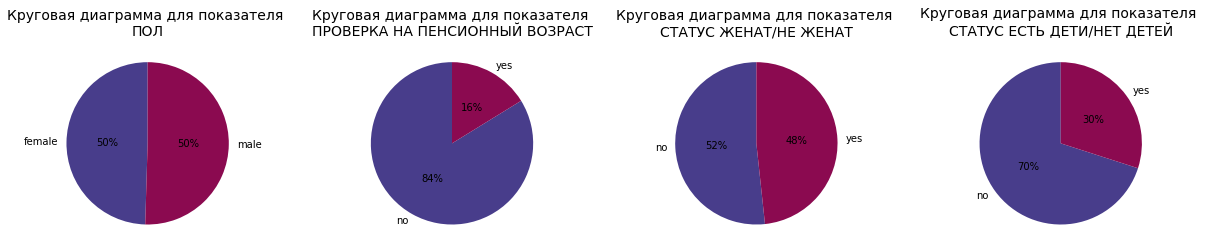

In [74]:
fig = plt.figure(figsize=(20,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['gender','senior_citizen', 'partner', 'dependents']
list_1 = ['пол', 'проверка на пенсионный возраст', 'статус женат/не женат', 'статус есть дети/нет детей']

for i in range(4):
    name = list[c]
    name_1 = list_1[list.index(name)]
    ax1 = plt.subplot2grid((1,4), (r, c))
    df1 = personal.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
    labels = df1.reset_index()[name]
    plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
    plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}', fontsize=14);
    c += 1
    i+=1 

#### ВЫВОД:
Исследовательский анализ данных personal показал, что:
- мужчины и жунщины в равной степени выбирают данный оператор связи.
- в основном данный оператор выбирают молодые люди, пенсионеры составляют 16%.
- данный оператор связи выбирают, практически, поровну как люди в браке, так и холостые. Отрыв в пользу холостых составляет 4%.
- данный оператор выбирают люди, которые не имеют детей, их 70% от всех пользоватлей.

### исследовательский анализ данных internet

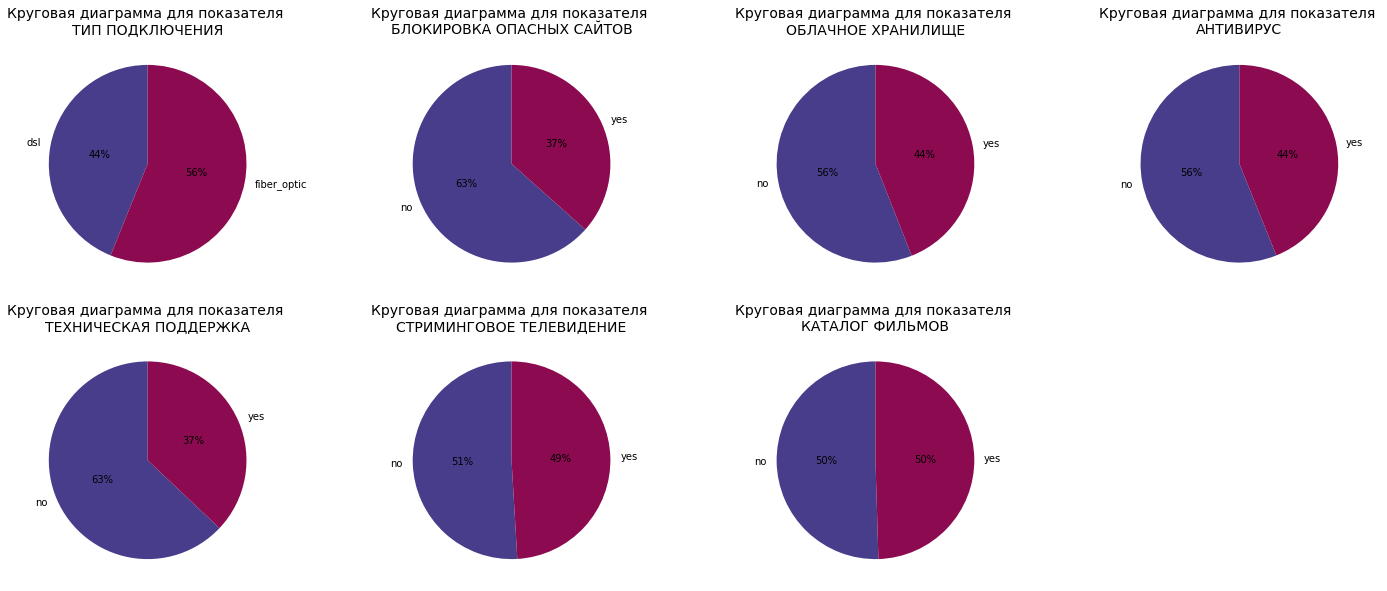

In [75]:
fig = plt.figure(figsize=(25,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)

list = ['internet_service', 'online_security', 'online_backup','device_protection',
       'tech_support', 'streaming_tv','streaming_movies']
list_1 = ['тип подключения', 'блокировка опасных сайтов','облачное хранилище', 'антивирус',
         'техническая поддержка', 'стриминговое телевидение', 'каталог фильмов']

for i in range(7):
    if c < 4:
        name = list[i]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((2,4), (r, c))
        df1 = internet.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90, 
                pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}', fontsize=14);
        c +=1 
        i+=1 
    else:
        name = list[i]
        name_1 = list_1[list.index(name)]
        c = 0 
        r = 1 
        ax1 = plt.subplot2grid((2,4), (r, c))
        df1 = internet.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90, 
                pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}', fontsize=14);
        c +=1
        if i < 6:
            i+=1

plt.show()

#### ВЫВОД:
Исследовательский анализ данных internet показал, что:
- пользователи предпочитают подключение fiber_optic(56%)
- клиенты предпочитают не пользоваться блокировкой опасных сайтов (63%)
- пользователи предпочитают не пользоваться хранилищем данных (63%) и также не пользоваться антивирусом (56%)
- клиенты чаще всего не пользуются выделенной линией поддержки (63%)
- пользователи, практически, в равной степени пользуются стриминговым телевидением(49% - да) и каталогом фильмов (50% - да)

### исследовательский анализ данных phone

<Figure size 720x360 with 0 Axes>

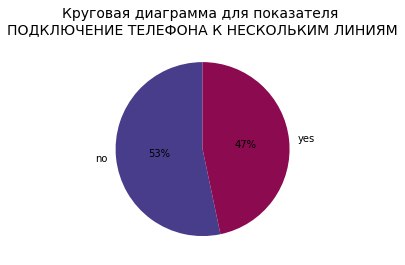

In [76]:
position = 0
plt.figure(figsize=[10,5]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['multiple_lines']
list_1 = ['подключение телефона к нескольким линиям']


for name in list:
    position += 1
    df1 = phone.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
    name_1 = list_1[list.index(name)]
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5
    );
    plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}', fontsize=14);
    plt.ylabel("");
    plt.legend().remove();
    plt.show();

#### ВЫВОД:
Исследовательский анализ данных phone показал, что:
- пользователи, практически, в равной степени пользуются подключением телефона к нескольким линиям, отличие составляет 6% в пользу не подключать.

### ВЫВОД:

Исследовательский анализ представленных данных показал, что:
- абоненты предпочитают оплату ежемесячную(55%), меньше всего берут оплату за два года.
- предпочитают оплату электронным расчётным листом(59%), хотя разрыв небольшой.
- оплату предпочитают проводить через электронные платежи (34%), остальные типы платежа распределились, практически, равномерно.
- средний расход на месяц составляет 70.3, максимальный - 118, минимальный - 18.25. Пик значений в районе 20 характерен для клиентов, которые оформляют договор и сразу его закрывают.
- средний общий расход составляет 1343. МИнимальный расход составляет 0 - это у тех клиентов, которые заключили договор 2020-02-01.
- клиенты, у которых за месяц меньше 21 (в районе пика), не являются клинтами, которые только заключили контракт 2020-02-01. Такие низкие данные за расчёты на месяц не являются анамалиями. Возможно эти клиенты не пользуются другими услугами оператора или пользуются очень малыми опциями.
- клиенты, у которых очень большие общие расходы, являются клиентами уже длительное время и возможно также пользуются дополнительными функциями от оператора. Низкие общие расходы, говорит о том, что пользователь только начал пользоваться данным оператором.
- мужчины и жунщины в равной степени выбирают данный оператор связи.
- в основном данный оператор выбирают молодые люди, пенсионеры составляют 16%.
- данный оператор связи выбирают, практически, поровну как люди в браке, так и холостые. Отрыв в пользу холостых составляет 4%.
- данный оператор выбирают люди, которые не имеют детей, их 70% от всех пользоватлей.
- пользователи предпочитают подключение fiber_optic(56%)
- клиенты предпочитают не пользоваться блокировкой опасных сайтов (63%)
- пользователи предпочитают не пользоваться хранилищем данных (63%) и также не пользоваться антивирусом (56%)
- клиенты чаще всего не пользуются выделенной линией поддержки (63%)
- пользователи, практически, в равной степени пользуются стриминговым телевидением(49% - да) и каталогом фильмов (50% - да)
- пользователи, практически, в равной степени пользуются подключением телефона к нескольким линиям, отличие составляет 6% в пользу не подключать.

## ШАГ. ОБЪЕДИНЕНИЕ ДАННЫХ.

На данном этапе необходимо провести обьединение всех данных в одну таблицу, не потеряв клиентов. Провести повторую предобработку данных, по возможности заполнить пропуски. Добавить новые столбцы с информацией являются ли пользователь еще клиентом данного оператора связи или нет и сколько времени времени пользователь является клиентом.

In [77]:
data = contract.merge(personal, how='left', on='customer_id')
data = data.merge(internet, how='left', on='customer_id')
data = data.merge(phone, how='left', on='customer_id')

In [78]:
display(data.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,month-to-month,yes,electronic_check,29.85,31.04,female,no,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-GNVDE,2017-04-01,No,one_year,no,mailed_check,56.95,2071.84,male,no,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,No,month-to-month,yes,mailed_check,53.85,226.17,male,no,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,No,one_year,no,bank_transfer,42.30,1960.60,male,no,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-HQITU,2019-09-01,No,month-to-month,yes,electronic_check,70.70,353.50,female,no,no,no,fiber_optic,no,no,no,no,no,no,no


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [80]:
print('Количество дубликотов строк в phone:',data.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(data.duplicated().sum() / phone.shape[0]* 100,3))
print('Количество строк:',data.shape[0])

Количество дубликотов строк в phone: 0
Процент дубликатов строк от всего количества строк: 0.0
Количество строк: 7043


In [81]:
data_id = data.set_index('customer_id')
print('Количество дубликотов строк в data без id:',data_id.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(data_id.duplicated().sum() / data_id.shape[0]* 100,3))

Количество дубликотов строк в data без id: 4
Процент дубликатов строк от всего количества строк: 0.057


In [82]:
print(data.isna().sum())

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


Поскольку пропуски наблюдаются в категорических признаках, их можно заменит на 'no' (считать, что пропуск - это отсутствие данного показателя) или 'other' (нет указания почему именно стоит пропуск, может у клиента подключена эта опция, но по каким-то причинам нет отображения). Пропуски будут заменены на 'other'.

In [83]:
data = data.fillna('other')

In [84]:
print(data.isna().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


Введем целевой признак 'user', который будет отвечать, пользуется ли клиент оператором или уже нет. "True" - не пользуется, "False" - является клиентом. Для дальнейшего удобства значение "True"  необходимо изменить на "yes", "False" - "no"

In [85]:
data['user'] = (data['end_date'] != 'No').astype(str).str.replace('True','yes').str.replace('False','no')

In [86]:
display(data[['end_date', 'user']].head(10))

,end_date,user
0,No,no
1,No,no
2,No,no
3,No,no
4,No,no
5,No,no
6,No,no
7,No,no
8,No,no
9,2017-05-01,yes


In [87]:
print(f'Количество пользователей, которые используют оператор, \nно в признаке показано, что они уже не клиенты:',data[['end_date', 'user']].query('end_date == "No" and user == "yes"')['user'].count())

Количество пользователей, которые используют оператор, 
но в признаке показано, что они уже не клиенты: 0


In [88]:
data['end_date'] = data['end_date'].str.replace('No','2020-02-01')

In [89]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')

data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

In [90]:
data['time'] = (data['end_date'] - data['begin_date']).dt.days

In [91]:
#print(data['time'])

In [92]:
display(data.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,user,time
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic_check,29.85,31.04,female,no,...,dsl,no,yes,no,no,no,no,other,no,31
1,5575-GNVDE,2017-04-01,2020-02-01,one_year,no,mailed_check,56.95,2071.84,male,no,...,dsl,yes,no,yes,no,no,no,no,no,1036
2,3668-QPYBK,2019-10-01,2020-02-01,month-to-month,yes,mailed_check,53.85,226.17,male,no,...,dsl,yes,yes,no,no,no,no,no,no,123
3,7795-CFOCW,2016-05-01,2020-02-01,one_year,no,bank_transfer,42.30,1960.60,male,no,...,dsl,yes,no,yes,yes,no,no,other,no,1371
4,9237-HQITU,2019-09-01,2020-02-01,month-to-month,yes,electronic_check,70.70,353.50,female,no,...,fiber_optic,no,no,no,no,no,no,no,no,153


### ВЫВОД:
Было прроведено объединение всех данных по столбцу customer_id.

Количество строк в объединенной таблице составляет: 7043 (что соотвествует количеству всех пользователей)

Явных дубликатов нет, но есть 4 дубликата без учёта customer_id, что составляет меньше 1% от всех данных. 

Поскольку пропуски наблюдаются в категорических признаках, их можно заменит на 'no' (считать, что пропуск - это отсутствие данного показателя) или 'other' (нет указания почему именно стоит пропуск, может у клиента подключена эта опция, но по каким-то причинам нет отображения). Пропуски будут заменены на 'other'.

Был добавлен целевой признак 'user', который будет отвечать, пользуется ли клиент оператором или уже нет. "True" - не пользуется, "False" - является клиентом. Для дальнейшего удобства значение "True"  изменено на "yes", "False" - "no".
Была проведена проверка на правильность заполнения. Было посчитано количество пользователей, которые используют оператор, но в признаке показано, что они уже не клиенты. Их 0. Заполнение произвошло корректно.

Также был введен столбец time, который показывает сколько дней, клиент пользуется оператором. Для этого в данных begin_date и end_date были был изменен тип на DateTime и в дальнейшем было произведено вычитание из конечной даты начальной. Разница представлена в днях.

## ШАГ. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И КОРРЕЛЯЦОННЫЙ АНАЛИЗ.

На данном этапе в исследовательском анализе необходимо построит портрет пользователя, который является клиентом и нет. Также провести корреляционный анализ.

### Портреты пользователей, которые являются клиентами и которые решили сменить оператора.

In [93]:
data_0 = data.query('user == "no"')

In [94]:
display(data_0.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,user,time
0,7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic_check,29.85,31.04,female,no,...,dsl,no,yes,no,no,no,no,other,no,31
1,5575-GNVDE,2017-04-01,2020-02-01,one_year,no,mailed_check,56.95,2071.84,male,no,...,dsl,yes,no,yes,no,no,no,no,no,1036
2,3668-QPYBK,2019-10-01,2020-02-01,month-to-month,yes,mailed_check,53.85,226.17,male,no,...,dsl,yes,yes,no,no,no,no,no,no,123
3,7795-CFOCW,2016-05-01,2020-02-01,one_year,no,bank_transfer,42.30,1960.60,male,no,...,dsl,yes,no,yes,yes,no,no,other,no,1371
4,9237-HQITU,2019-09-01,2020-02-01,month-to-month,yes,electronic_check,70.70,353.50,female,no,...,fiber_optic,no,no,no,no,no,no,no,no,153


In [95]:
data_1 = data.query('user == "yes"')

In [96]:
display(data_1.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,user,time
9,6388-TABGU,2014-12-01,2017-05-01,one_year,no,bank_transfer,56.15,1628.35,male,no,...,dsl,yes,yes,no,no,no,no,no,yes,882
15,3655-SNQYZ,2014-05-01,2016-03-01,two_year,no,credit_card,113.25,2491.50,female,no,...,fiber_optic,yes,yes,yes,yes,yes,yes,yes,yes,670
25,6865-JZNKO,2017-08-01,2018-09-01,month-to-month,yes,bank_transfer,55.30,726.09,female,no,...,dsl,yes,yes,no,no,no,no,no,yes,396
30,3841-NFECX,2014-03-01,2018-11-01,two_year,yes,credit_card,96.35,5395.60,female,yes,...,fiber_optic,yes,yes,yes,yes,no,no,yes,yes,1706
35,6234-RAAPL,2014-02-01,2018-12-01,two_year,no,bank_transfer,99.90,5794.20,female,no,...,fiber_optic,yes,yes,no,yes,yes,no,yes,yes,1764


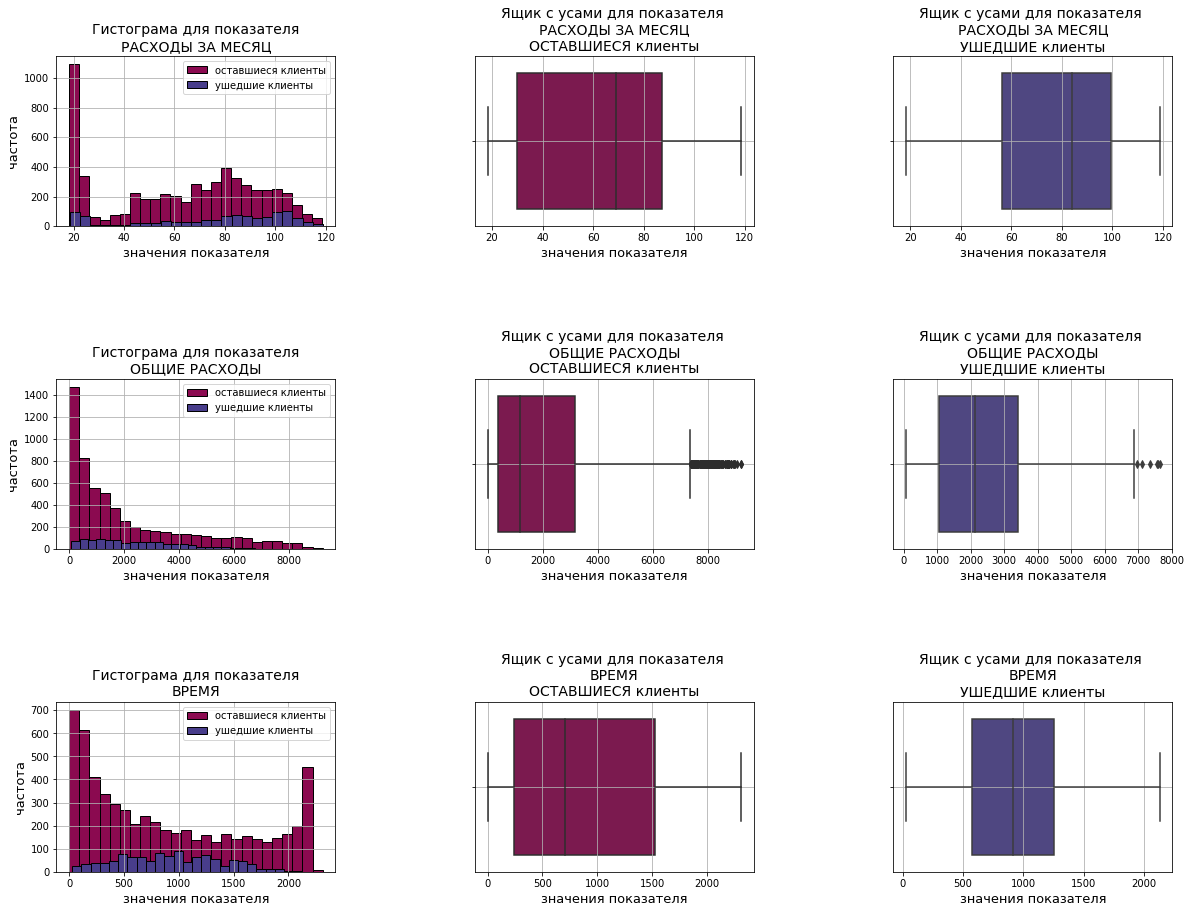

In [97]:
fig = plt.figure(figsize=(20,15))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.9);

list = ['monthly_charges','total_charges', 'time']
list_1 = ['расходы за месяц', 'общие расходы', 'время']


for i in range(9):
    if c == 0:
        name = list[r]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((3,3), (r, c))
        df0 = data_0[name]
        df1 = data_1[name]
        df0.plot(kind = 'hist', color = '#8B0A50', bins = 25, edgecolor='black',label='оставшиеся клиенты')
        df1.plot(kind = 'hist', color = '#483D8B', bins = 25, edgecolor='black',label='ушедшие клиенты')         
        plt.title(f'Гистограма для показателя\n{name_1.upper()}', fontsize=14)
        plt.xlabel('значения показателя', fontsize=13)
        plt.legend()         
        plt.ylabel('частота', fontsize=13)
        plt.grid(True)
        c +=1 
        i+=1 
    if c == 1:
        name = list[r]
        name_1 = list_1[list.index(name)]
        df0 = data_0[name]
        ax1 = plt.subplot2grid((3,3), (r, c))
        sns.boxplot(x= df0,color = '#8B0A50')
        plt.title(f'Ящик с усами для показателя \n{name_1.upper()}\nОСТАВШИЕСЯ клиенты', fontsize=14)
        plt.xlabel('значения показателя',fontsize=13 )
        plt.grid(True)
        c +=1 
        i+=1
    if c == 2:
        name = list[r]
        name_1 = list_1[list.index(name)]
        df1 = data_1[name]
        ax1 = plt.subplot2grid((3,3), (r, c))
        sns.boxplot(x= df1,color = '#483D8B')
        plt.title(f'Ящик с усами для показателя \n{name_1.upper()}\nУШЕДШИЕ клиенты', fontsize=14)
        plt.xlabel('значения показателя',fontsize=13 )
        plt.grid(True)
        c = 0
        i+=1
        if r < 2:
            r += 1

In [98]:
print(f'Характеристики количественных показателей ОСТАВШИХСЯ клиентов') 
display(data_0.describe())

Характеристики количественных показателей ОСТАВШИХСЯ клиентов


,monthly_charges,total_charges,time
count,5942.000000,5942.000000,5942.000000
mean,62.763455,2067.866420,893.681084
std,29.844462,2193.898483,716.958551
min,18.250000,0.000000,0.000000
25%,30.062500,374.352500,245.000000
50%,69.200000,1192.800000,702.000000
75%,87.237500,3173.837500,1523.000000
max,118.600000,9221.380000,2314.000000


In [99]:
print(f'Характеристики количественных показателей УШЕДШИХ клиентов') 
display(data_1.describe())

Характеристики количественных показателей УШЕДШИХ клиентов


,monthly_charges,total_charges,time
count,1101.000000,1101.000000,1101.000000
mean,75.546004,2371.377275,924.863760
std,29.116213,1581.862275,458.771309
min,18.400000,77.840000,28.000000
25%,56.150000,1048.050000,577.000000
50%,84.200000,2139.030000,915.000000
75%,99.500000,3404.910000,1249.000000
max,118.750000,7649.760000,2129.000000


Для пользователя, который продолжает пользоваться оператором связи:
- средние расходы на месяц составляют - 69.2, минимальные расходы - 18.2, максимальные - 118.6
- общие расходы составляют в среднем - 1192, минимальные расходы - 0(только пришедшие клиенты), максимальные - 9221
- общее время пользования оператором в среднем - 893 дня, минимальное - 0(только пришедшие клиенты), максимальное - 2314 дней.
- оператор выбирают как мужчины так и женщины (поровну), большей части это молодые и зрелые люди (доля пенсионеров составляет 15%), больше половины (55%) являются неженатыми и у более 71% отсутствуют дети.

Для пользователей, который уже не пользуется данным оператором:
- средний расход за месяц составляет 75.5, минимальный расход за месяц - 18.4, максимальный - 118.8
- средний общий расход составлял 2371, минимальные расходы - 77.8, максимальный - 7649.
- среднее время использования данного оператора -  924.8 дней, минимальное время - 28 дней, максимальное - 2129.

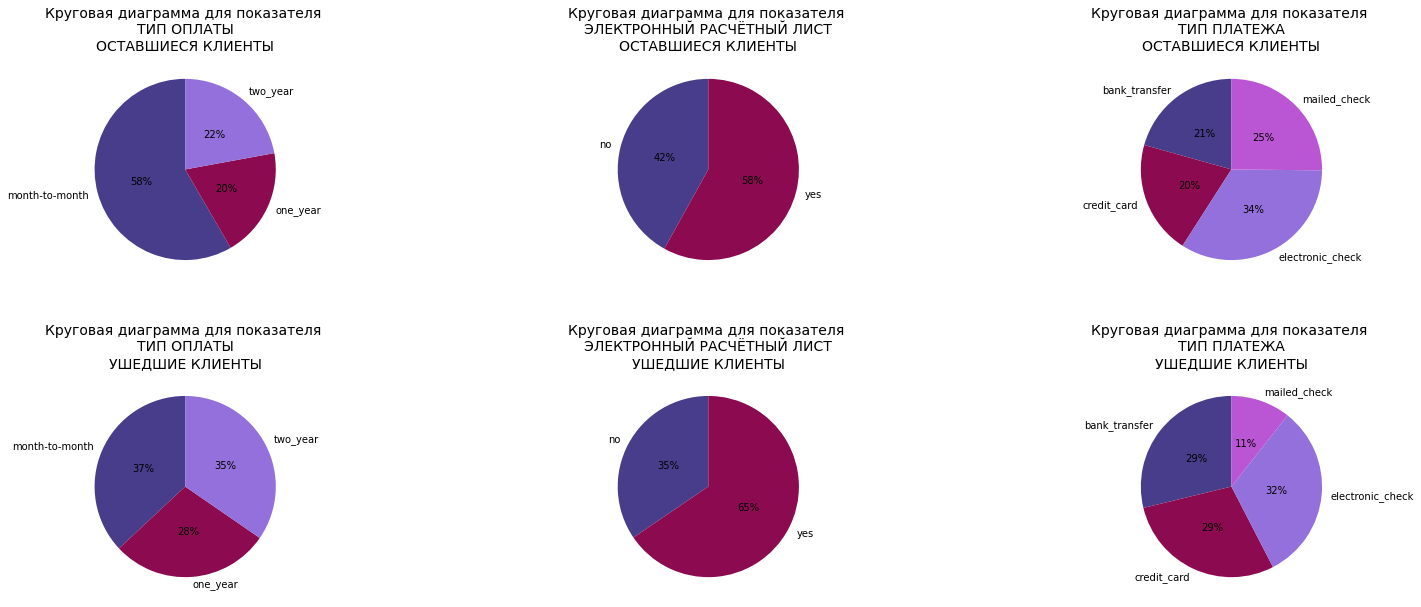

In [100]:
fig = plt.figure(figsize=(25,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['type','paperless_billing',  'payment_method']
list_1 = ['тип оплаты', 'электронный расчётный лист', 'тип платежа']

for i in range(6):
    if c < 3:
        name = list[c]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((2,3), (r, c))
        df0 = data_0.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df0.reset_index()[name]
        plt.pie(df0['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nОСТАВШИЕСЯ КЛИЕНТЫ', fontsize=14);
        c +=1 
        i+=1 
    else:
        c = c - 3 
        name = list[c]
        name_1 = list_1[list.index(name)]
        r = 1 
        ax1 = plt.subplot2grid((2,3), (r, c))
        df1 = data_1.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nУШЕДШИЕ КЛИЕНТЫ', fontsize=14);
        c +=4
        i+=1

Для пользователя, который продолжает пользоваться оператором связи:
- тип оплаты предпочтителен ежемесячный (составляет 58%), самый невыгодный,по мнению клиентов, - ежегодный договор(выбирают 20%)
- предпочитают расчётные листы (58%)
- популярный тип платежа - электронные чеки (34%), самый нераспространенный - кредитные карты(20%)

Для пользователя, который уже не пользуется данным оператором:
- больше всего пользовались оплатой ежемесячной (37%), меньше всего пользовались оплатой за 1 год (28%)
- клиенты часто запрашивали электронный расчётный лист (65%)
- самый часто используемый тип платежа - электронные чеки (32%), меньше всегопользовались чеками по почте(11%)

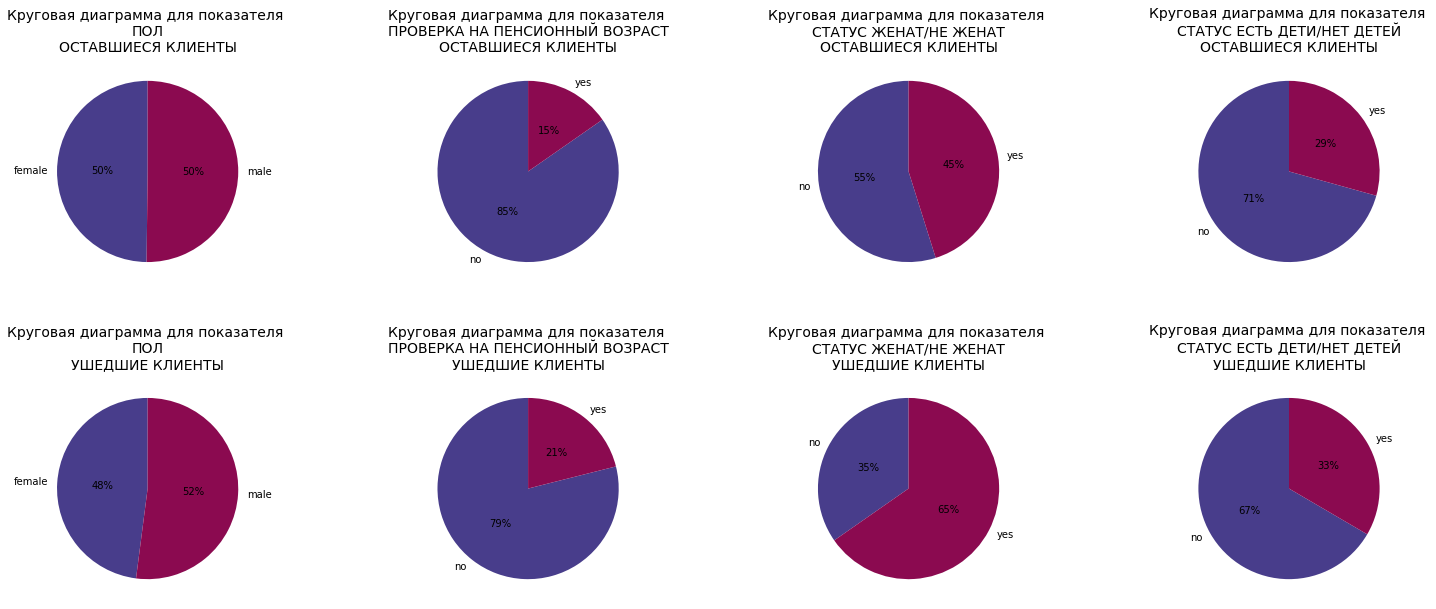

In [101]:
fig = plt.figure(figsize=(25,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['gender','senior_citizen', 'partner', 'dependents']
list_1 = ['пол', 'проверка на пенсионный возраст', 'статус женат/не женат', 'статус есть дети/нет детей']

for i in range(8):
    if c < 4:
        name = list[c]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((2,4), (r, c))
        df0 = data_0.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df0.reset_index()[name]
        plt.pie(df0['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nОСТАВШИЕСЯ КЛИЕНТЫ', fontsize=14);
        c +=1 
        i+=1 
    else:
        c = c - 4 
        name = list[c]
        name_1 = list_1[list.index(name)]
        r = 1 
        ax1 = plt.subplot2grid((2,4), (r, c))
        df1 = data_1.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nУШЕДШИЕ КЛИЕНТЫ', fontsize=14);
        c +=5
        i+=1

Портрет пользователя, который продолжает пользоваться оператором связи:
- оператор выбирают как мужчины так и женщины (поровну), большей части это молодые и зрелые люди (доля пенсионеров составляет 15%), больше половины (55%) являются неженатыми и у более 71% отсутствуют дети.

Портрет пользователя, который уже не пользуется данным оператором:
- клиенты, в большей части, - мужчины(52%), молодые и зрелые люди(пенсионеры составляют 21%), большая часть женаты/замужем(65%), без детей(67%).

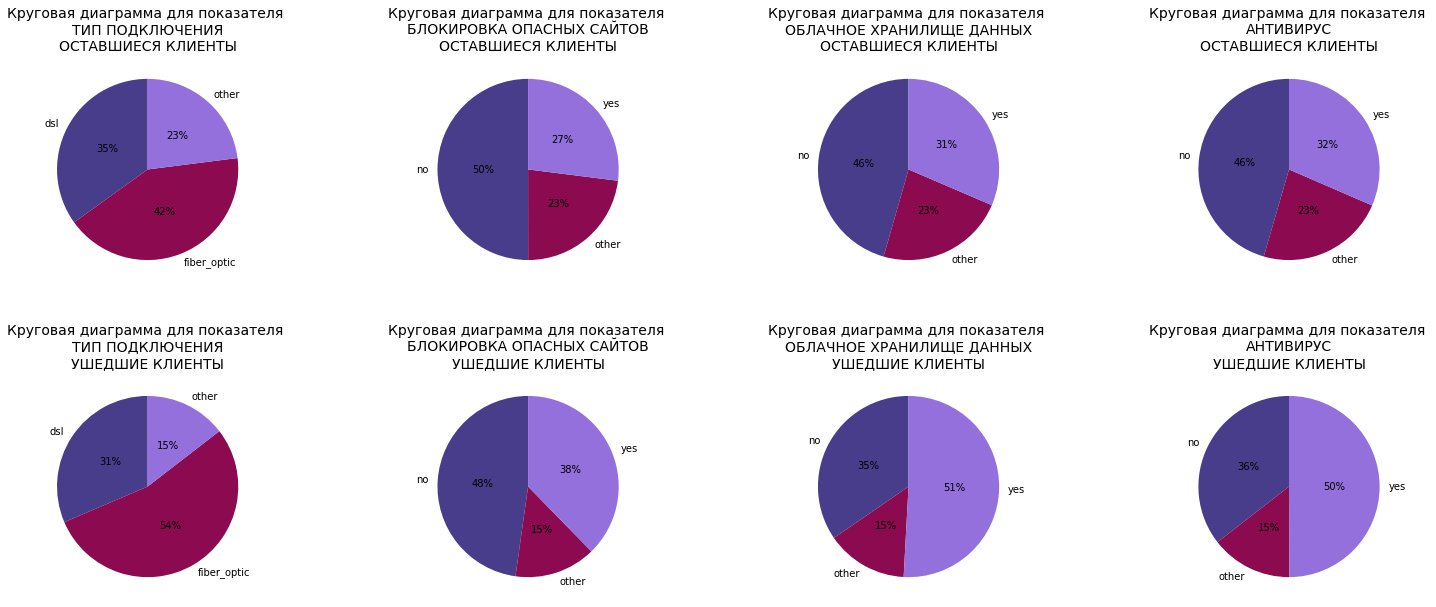

In [102]:
fig = plt.figure(figsize=(25,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['internet_service', 'online_security', 'online_backup','device_protection']
list_1 = ['тип подключения', 'блокировка опасных сайтов','облачное хранилище данных', 'антивирус']

for i in range(8):
    if c < 4:
        name = list[c]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((2,4), (r, c))
        df0 = data_0.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df0.reset_index()[name]
        plt.pie(df0['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nОСТАВШИЕСЯ КЛИЕНТЫ', fontsize=14);
        c +=1 
        i+=1 
    else:
        c = c - 4 
        name = list[c]
        name_1 = list_1[list.index(name)]
        r = 1 
        ax1 = plt.subplot2grid((2,4), (r, c))
        df1 = data_1.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nУШЕДШИЕ КЛИЕНТЫ', fontsize=14);
        c +=5
        i+=1

Портрет пользователя, который продолжает пользоваться оператором связи:
- тип подключения предпочитают fiber_optic (42%)
- только 27% выбирают услугу брокировка опасных сайтов, 50% - данной опцией не пользуются
- пользователи также плохо используют облачное хранение, лишь 31%, 46% - не нуждаются в этом
- антивирусом также пользователи не использкют, лишь 32% его активировало.

Портрет пользователя, который уже не пользуется данным оператором:
- тип подключения предпочитают fiber_optic (54%)
- не пользовались блокировкой опасных сайтой(48%), но пользовались облачным зранилищем (51%) и предпочитали использовать антивирус (50%)

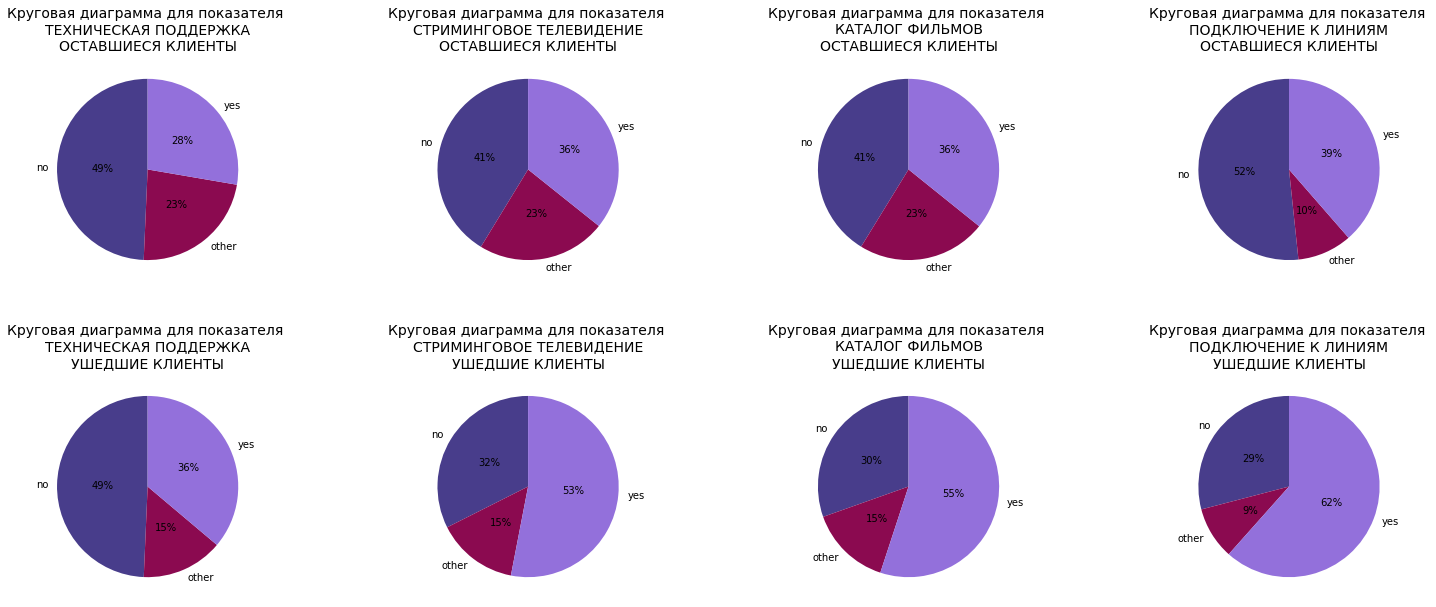

In [103]:
fig = plt.figure(figsize=(25,10))
i= 0 
r,c = 0 ,0   # rows(r) and columns(c)
plt.subplots_adjust(wspace=0.5, hspace=0.4);

list = ['tech_support', 'streaming_tv','streaming_movies', 'multiple_lines']
list_1 = ['техническая поддержка', 'стриминговое телевидение', 'каталог фильмов', 'подключение к линиям']

for i in range(8):
    if c < 4:
        name = list[c]
        name_1 = list_1[list.index(name)]
        ax1 = plt.subplot2grid((2,4), (r, c))
        df0 = data_0.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df0.reset_index()[name]
        plt.pie(df0['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nОСТАВШИЕСЯ КЛИЕНТЫ', fontsize=14);
        c +=1 
        i+=1 
    else:
        c = c - 4 
        name = list[c]
        name_1 = list_1[list.index(name)]
        r = 1 
        ax1 = plt.subplot2grid((2,4), (r, c))
        df1 = data_1.pivot_table(index = name, values = 'customer_id', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['customer_id'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
        startangle=90, 
        pctdistance=0.5)
        plt.title(f'Круговая диаграмма для показателя \n{name_1.upper()}\nУШЕДШИЕ КЛИЕНТЫ', fontsize=14);
        c +=5
        i+=1

Портрет пользователя, который продолжает пользоваться оператором связи:
- технической поддержкой ползователи не интерисуются (49% из данных)
- стриминговое телевидение используют 36% процентов пользователей, такое же распределение и у каталога каналов.
- подключением телефона к нелькольким линиям актуально лишь для 39%, 52% в нем точно не нуждаются.

Портрет пользователя, который уже не пользуется данным оператором:
- не пользовались технической поддержкой (49%)
- использовали стриминговое телевидение(53%), каталогом фильмов(55%)
- клиенты подключали телефоны к нескольким линиям(62%)

#### ВЫВОД:
Портрет пользователя, который продолжает пользоваться оператором связи:
- тип оплаты предпочтителен ежемесячный (составляет 58%), самый невыгодный,по мнению клиентов, - ежегодтчный договор(выбирают 20%)
- предпочитают расчётные листы (58%)
- популярный тип платежа - электронные чеки (34%), самый нераспространенный - кредитные карты(20%)
- средние расходы на месяц составляют - 69.2, минимальные расходы - 18.2, максимальные - 118.6
- общие расходы составляют в среднем - 1192, минимальные расходы - 0(только пришедшие клиенты), максимальные - 9221
- общее время пользования оператором в среднем - 893 дня, минимальное - 0(только пришедшие клиенты), максимальное - 2314 дней.
- оператор выбирают как мужчины так и женщины (поровну), большей части это молодые и зрелые люди (доля пенсионеров составляет 15%), больше половины (55%) являются неженатыми и у более 71% отсутствуют дети.
- тип подключения предпочитают fiber_optic (42%)
- только 27% выбирают услугу брокировка опасных сайтов, 50% - данной опцией не пользуются
- пользователи также плохо используют облачное хранение, лишь 31%, 46% - не нуждаются в этом
- антивирусом также пользователи не использкют, лишь 32% его активировало.
- технической поддержкой ползователи не интерисуются (49% из данных)
- стриминговое телевидение используют 36% процентов пользователей, такое же распределение и у каталога каналов.
- подключением телефона к нелькольким линиям актуально лишь для 39%, 52% в нем точно не нуждаются.

Портрет пользователя, который уже не пользуется данным оператором:
- потребитель больше всего пользовался оплатой ежемесячной (37%), меньше всего пользовались оплатой за 1 год (28%)
- клиенты часто запрашивали электронный расчётный лист (65%)
- самый часто используемый тип платежа - электронные чеки (32%), меньше всегопользовались чеками по почте(11%)
- средний расход за месяц составляет 75.5, минимальный расход за месяц - 18.4, максимальный - 118.8
- средний общий расход составлял 2371, минимальные расходы - 77.8, максимальный - 7649.
- среднее время использования данного оператора -  924.8 дней, минимальное время - 28 дней, максимальное - 2129.
- клиенты, в большей части, - мужчины(52%), молодые и зрелые люди(пенсионеры составляют 21%), большая часть женаты/замужем(65%), без детей(67%).
- тип подключения предпочитают fiber_optic (54%)
- не пользовались блокировкой опасных сайтой(48%), но пользовались облачным зранилищем (51%) и предпочитали использовать антивирус (50%)
- не пользовались технической поддержкой (49%)
- использовали стриминговое телевидение(53%), каталогом фильмов(55%)
- клиенты подключали телефоны к нескольким линиям(62%)

### корреляционный анализ

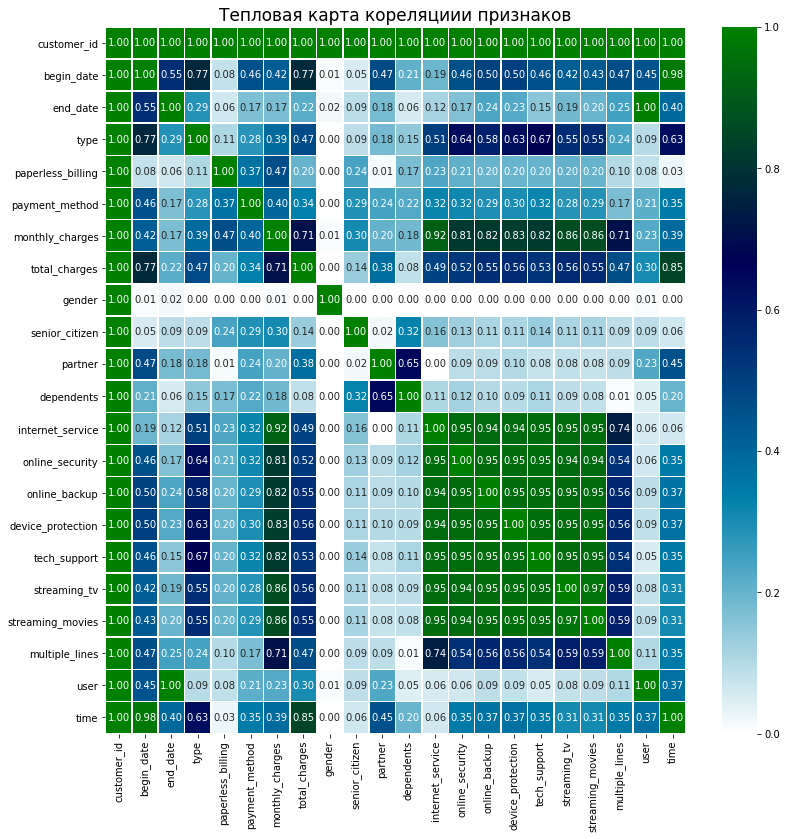

In [104]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'time'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap = "ocean_r"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

In [105]:
drop_columns = ['begin_date', 'end_date', 'customer_id']
data = data.drop(drop_columns, axis =1)

In [106]:
display(data.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,user,time
0,month-to-month,yes,electronic_check,29.85,31.04,female,no,yes,no,dsl,no,yes,no,no,no,no,other,no,31
1,one_year,no,mailed_check,56.95,2071.84,male,no,no,no,dsl,yes,no,yes,no,no,no,no,no,1036
2,month-to-month,yes,mailed_check,53.85,226.17,male,no,no,no,dsl,yes,yes,no,no,no,no,no,no,123
3,one_year,no,bank_transfer,42.30,1960.60,male,no,no,no,dsl,yes,no,yes,yes,no,no,other,no,1371
4,month-to-month,yes,electronic_check,70.70,353.50,female,no,no,no,fiber_optic,no,no,no,no,no,no,no,no,153


In [107]:
print('Количество строк:',data.shape[0])

Количество строк: 7043


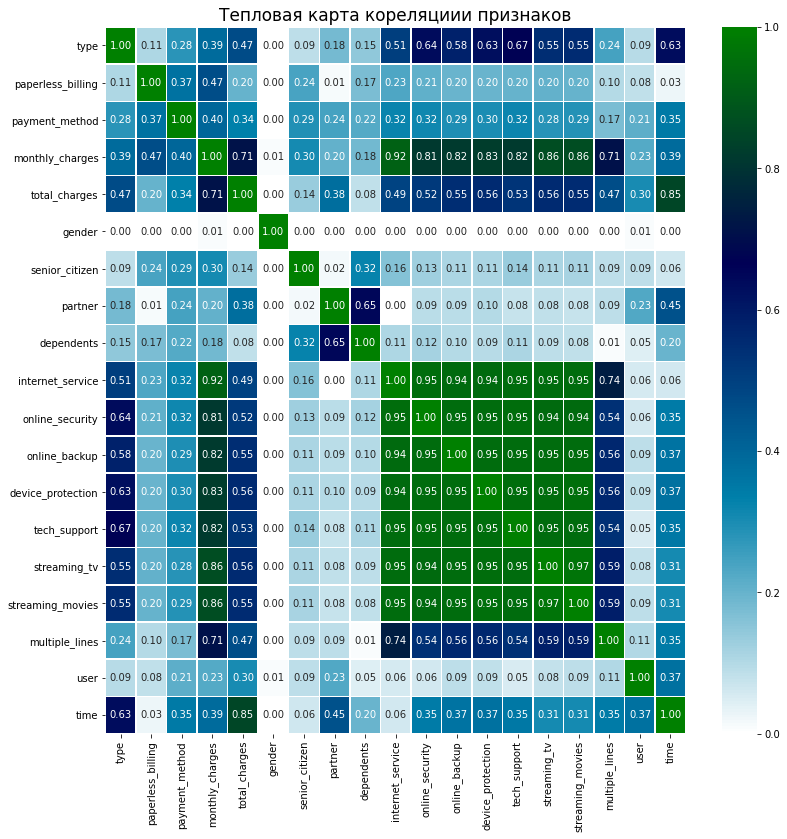

In [108]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'time'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap = "ocean_r"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

In [109]:
drop_columns = ['gender','tech_support']
data = data.drop(drop_columns, axis =1)

In [110]:
drop_columns = ['internet_service']
data = data.drop(drop_columns, axis =1)

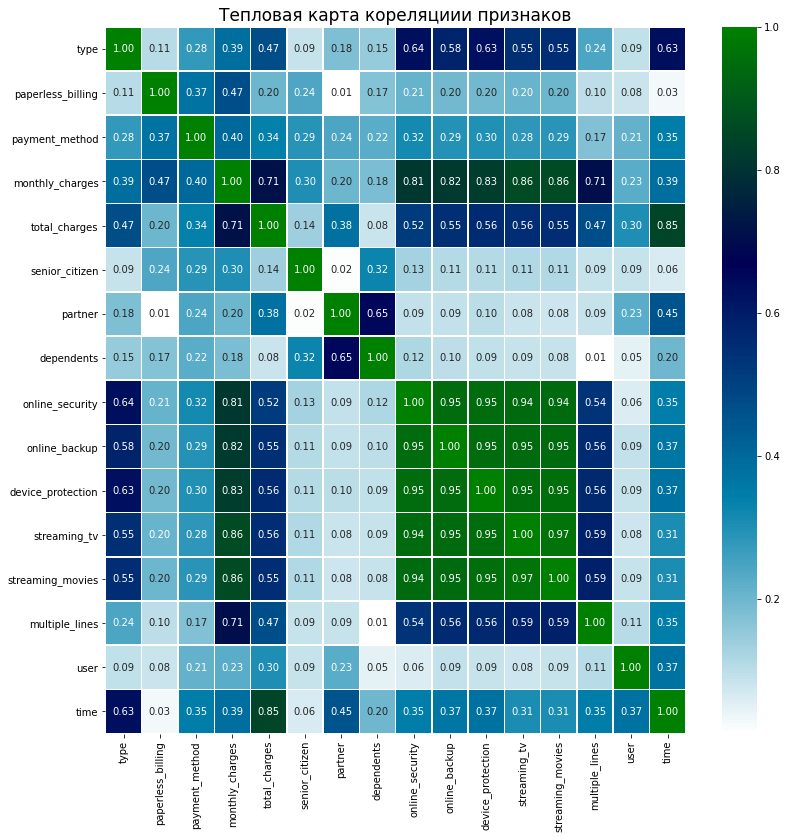

In [111]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'time'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap = "ocean_r"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

#### ВЫВОД:
Корреляционный анализ показал, что таргет user сильно коррелирует с end_date, customer_id(с данными признаками существвует мультиколлинеарность). Данные признаки были удалены, также был удален признак begin_date(наиболее информативный является time, begin_date может негативно влиять на модель). 

Также мультиколлинеарность наблюжается у признаков:
- internet_service
- online_security
- online_backup
- device_protection
- streaming_tv
- streaming_movies

Было принято решение удалить из выше представленного списка признаки, у которых очень слабая корреляция с таргетом.
Это признаки: 
- tech_support
- internet_service

Слабую корреляцию показали количественные призаки, категорические признаки показали, практически, отсутвие корреляции. Категорические признаки с самой низкой корреляцией:
- gender(0.01)
- dependents(0.05)
- tech_support(0.05)

Поскольку gender не оказывает воздействия на таргет, было принято решение его удалить.

### ВЫВОД:

Портрет пользователя, который продолжает пользоваться оператором связи:
- тип оплаты предпочтителен ежемесячный (составляет 58%), самый невыгодный,по мнению клиентов, - ежегодтчный договор(выбирают 20%)
- предпочитают расчётные листы (58%)
- популярный тип платежа - электронные чеки (34%), самый нераспространенный - кредитные карты(20%)
- средние расходы на месяц составляют - 69.2, минимальные расходы - 18.2, максимальные - 118.6
- общие расходы составляют в среднем - 1192, минимальные расходы - 0(только пришедшие клиенты), максимальные - 9221
- общее время пользования оператором в среднем - 893 дня, минимальное - 0(только пришедшие клиенты), максимальное - 2314 дней.
- оператор выбирают как мужчины так и женщины (поровну), большей части это молодые и зрелые люди (доля пенсионеров составляет 15%), больше половины (55%) являются неженатыми и у более 71% отсутствуют дети.
- тип подключения предпочитают fiber_optic (42%)
- только 27% выбирают услугу брокировка опасных сайтов, 50% - данной опцией не пользуются
- пользователи также плохо используют облачное хранение, лишь 31%, 46% - не нуждаются в этом
- антивирусом также пользователи не использкют, лишь 32% его активировало.
- технической поддержкой ползователи не интерисуются (49% из данных)
- стриминговое телевидение используют 36% процентов пользователей, такое же распределение и у каталога каналов.
- подключением телефона к нелькольким линиям актуально лишь для 39%, 52% в нем точно не нуждаются.

Портрет пользователя, который уже не пользуется данным оператором:
- потребитель больше всего пользовался оплатой ежемесячной (37%), меньше всего пользовались оплатой за 1 год (28%)
- клиенты часто запрашивали электронный расчётный лист (65%)
- самый часто используемый тип платежа - электронные чеки (32%), меньше всегопользовались чеками по почте(11%)
- средний расход за месяц составляет 75.5, минимальный расход за месяц - 18.4, максимальный - 118.8
- средний общий расход составлял 2371, минимальные расходы - 77.8, максимальный - 7649.
- среднее время использования данного оператора -  924.8 дней, минимальное время - 28 дней, максимальное - 2129.
- клиенты, в большей части, - мужчины(52%), молодые и зрелые люди(пенсионеры составляют 21%), большая часть женаты/замужем(65%), без детей(67%).
- тип подключения предпочитают fiber_optic (54%)
- не пользовались блокировкой опасных сайтой(48%), но пользовались облачным зранилищем (51%) и предпочитали использовать антивирус (50%)
- не пользовались технической поддержкой (49%)
- использовали стриминговое телевидение(53%), каталогом фильмов(55%)
- клиенты подключали телефоны к нескольким линиям(62%)

Корреляционный анализ показал, что таргет user сильно коррелирует с end_date, customer_id(с данными признаками существвует мультиколлинеарность). Данные признаки были удалены, также был удален признак begin_date(наиболее информативный является time, begin_date может негативно влиять на модель). 

Также мультиколлинеарность наблюжается у признаков:
- internet_service
- online_security
- online_backup
- device_protection
- streaming_tv
- streaming_movies

Было принято решение удалить из выше представленного списка признаки, у которых очень слабая корреляция с таргетом.
Это признаки: 
- tech_support
- internet_service

Слабую корреляцию показали количественные призаки, категорические признаки показали, практически, отсутвие корреляции. Категорические признаки с самой низкой корреляцией:
- gender(0.01)
- dependents(0.05)
- tech_support(0.05)

Поскольку gender не оказывает воздействия на таргет, было принято решение его удалить.

## ШАГ. ПОДГОТОВКА ДАННЫХ.

На данном этапе необходимо подготовить данные к обучению, провести разделение выборки на тренировочную и тестовую, основываясь на анализе баланса классов.

In [112]:
print('количество строк:' ,data.shape[0])

количество строк: 7043


Прежде чем делать разделение на выборки и проводить обучение модели, необходимо посмотреть как разделен целевой показатель. Если 1:1 - можно проводить обучение, если разделение будет иным, придется это учитывать и производить при обучении модели баланс классов

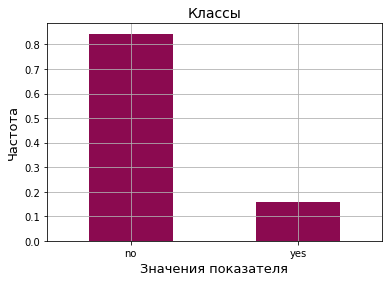

In [113]:
data['user'].value_counts(normalize=True).plot(kind='bar', color = '#8B0A50')
plt.title('Классы',fontsize=14)
plt.xlabel('Значения показателя', fontsize=13)
plt.ylabel('Частота', fontsize=13)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

**ВЫВОД**:
Датасет разбит в пропорции, приблизительно 3:1. Необходимо будет применять стратификацию по целевой переменной(чтобы сохранить баланс).

In [114]:
X = data.drop('user', axis=1)
y = data['user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [115]:
print(
    f'Разделение выборки в следующих пропорциях:\n'
    f'{(len(X_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(X_test)/len(data)):.0%} — тестовая;'
)

Разделение выборки в следующих пропорциях:
75% — тренировочная;
25% — тестовая;


In [116]:
print(
    f'Размер матриц:\n'
    f'{X_train.shape[0], y_train.shape[0]} — тренировочная;\n'
    f'{X_test.shape[0], y_test.shape[0]} — тестовая;\n'
)

Размер матриц:
(5282, 5282) — тренировочная;
(1761, 1761) — тестовая;



### ВЫВОД:
В ходе подготовки данных к обучению было сделано:
- после проверки на баланс классов было выявлено, что они разбиты 3:1, что свидетельствует о необходимости стратификации данных.
- данные были разделены на тренировочную и тестовую, также была проведена проверка разделения и размер матриц.
- в треннировочных и тестовых данных наблюдаются различия по матрицам, при обучении необходимо будет воспользоваться балансом.

## ШАГ. ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ

На данном этапе необходимо обучить три модели: логистическая регрессия, случайный лес и бустинг.
Для каждой архитектуры подобрать гиперпараметры и выбрать лучшую моделт на метрике  AUC-ROC >= 0.85, если метрика будет приближаться к 100% - идет переобучение, тогда необходимо изменить подбор параметров, проконтролировать утечку. Также необходимо при обучении учитывать баланс классов.

In [117]:
num_columns = ['monthly_charges', 'total_charges','time']  
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup',
       'device_protection', 'streaming_tv', 'streaming_movies',
       'multiple_lines']
ord_columns = ['type', 'paperless_billing','payment_method', 'senior_citizen', 'partner', 'dependents',
       'online_security', 'online_backup','device_protection', 'streaming_tv', 'streaming_movies',
       'multiple_lines']

In [118]:
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error'))])

In [119]:
 ord_pipe = Pipeline([('ord',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan))])

In [120]:
num_pipe = Pipeline([('robustscaler', RobustScaler()),
                ('powertransform', PowerTransformer())])

In [121]:
data_preprocessor_lir = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num',  num_pipe, num_columns)],
    remainder='passthrough'
)

In [122]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

### модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [123]:
pipe_lir = Pipeline(
    [
        ('preprocessor', data_preprocessor_lir),
        ('lir', LogisticRegression(class_weight = 'balanced',solver='liblinear', penalty='l1', random_state=RANDOM_STATE))
    
    ]
)

In [124]:
parameters_lir = {
    'lir__C': [1, 10, 50, 100, 150], 
    'lir__max_iter': [10, 50, 100],  
}

In [125]:
lir_grid = GridSearchCV(pipe_lir, parameters_lir, cv=3, scoring='roc_auc', verbose=False, n_jobs=-1, error_score = 'raise')

In [126]:
%%time

lir_grid.fit(X_train, y_train)

lir_fit_score = lir_grid.best_score_
print('Лучшая модель и её параметры:', lir_grid.best_estimator_)
print(f'Лучший показатель ROC-AUC: {lir_fit_score:.3f}')

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'streaming_tv',
                                                   'streaming_movies',
     

### модель СЛУЧАЙНЫЙ ЛЕС

In [127]:
pipe_random = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('random', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced',verbose=False ))
    ]
)

In [128]:
param_random = {
    'random__n_estimators': [90,100,125,150],
    'random__max_depth': range(1,10)
}

In [129]:
random_grid = GridSearchCV(pipe_random, param_random, scoring='roc_auc', cv=3, n_jobs=-1, error_score = 'raise')

In [130]:
%%time

random_grid.fit(X_train, y_train)
random_fit_score = random_grid.best_score_
print('Лyчшая модель и её параметры:', random_grid.best_estimator_)
print(f'Лучший показатель ROC-AUC: {random_fit_score:.3f}')

Лyчшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                   

### модель БУСТИНГ

In [131]:
pipe_cat = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('cat', CatBoostClassifier(random_state = RANDOM_STATE,logging_level='Silent', loss_function='Logloss'))
    ]
)

In [132]:
param_cat = {
        'cat__depth': range(4, 10),
        'cat__learning_rate':np.arange(0.1,1,0.2)
}

In [133]:
cat_grid = GridSearchCV(pipe_cat, param_cat, scoring='roc_auc', cv=3, n_jobs=-1, error_score = 'raise')

In [134]:
%%time

cat_grid.fit(X_train, y_train)
cat_fit_score = cat_grid.best_score_
print('Лyчшая модель и её параметры:', cat_grid.best_estimator_)
print(f'Лучший показатель ROC-AUC: {cat_fit_score:.3f}')

Лyчшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                   

In [135]:
best_model = cat_grid.best_estimator_
catboost_model = best_model.named_steps['cat']
catboost_model

In [136]:
display(catboost_model.get_params())

{'learning_rate': 0.1,
 'depth': 4,
 'loss_function': 'Logloss',
 'logging_level': 'Silent',
 'random_state': 28072025}

In [137]:
table = [
    ['LogisticRegression','C=50,max_iter=10,\npenalty="l1", solver="liblinear",\nclass_weight="balanced", random_state=28072025', 0.747], 
    ['RandomForestClassifier', 'max_depth=6, n_estimators=125, verbose="False",\nclass_weight="balanced", random_state=28072025', 0.830],
    ['CatBoostClassifier','learning_rate=0.1, depth=4,\nloss_function="Logloss", logging_level="Silent",\nclass_weight="balanced", random_state=28072025', 0.897]
]

columns = ['model', 'parameters', 'ROC_AUC']

print(tabulate(table,headers=columns, tablefmt='fancy_grid', colalign=("center", "center", "center")))

╒════════════════════════╤══════════════════════════════════════════════════╤═══════════╕
│         model          │                    parameters                    │  ROC_AUC  │
╞════════════════════════╪══════════════════════════════════════════════════╪═══════════╡
│   LogisticRegression   │                C=50,max_iter=10,                 │   0.747   │
│                        │        penalty="l1", solver="liblinear",         │           │
│                        │  class_weight="balanced", random_state=28072025  │           │
├────────────────────────┼──────────────────────────────────────────────────┼───────────┤
│ RandomForestClassifier │ max_depth=6, n_estimators=125, verbose="False",  │   0.83    │
│                        │  class_weight="balanced", random_state=28072025  │           │
├────────────────────────┼──────────────────────────────────────────────────┼───────────┤
│   CatBoostClassifier   │           learning_rate=0.1, depth=4,            │   0.897   │
│         

### ВЫВОД

Было обучено 3 модели: логистическая регрессия, случайный лес и бустинг. Для каждой архитектуры были подобраны гиперпараметры. Лучшую метрику ROC-AUC = 0.897 на тренировочной модели показал CatBoostClassifier.
Ниже приведена таблица с моделями их параметрами и метриками:

## ШАГ. ИССЛЕДОВАНИЕ МОДЕЛИ. 

На данном этапе необходимо провести проверку выбранной модели на тестовых данных.Построить ROC-кривую и матрицу ошибок. Провести анализ полученных результатов. Провести анализ важности признаков. 

In [138]:
predict = cat_grid.best_estimator_.predict_proba(X_test)[:, 1]

In [139]:
roc_auc = roc_auc_score(y_test, predict)

print('AUC-ROC на тестовом наборе данных:', round(roc_auc, 3))

AUC-ROC на тестовом наборе данных: 0.931


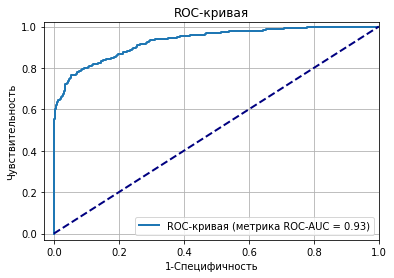

In [140]:
y_test_1 = y_test.str.replace('yes','1').str.replace('no','0').astype(int)
fpr, tpr, thresholds = roc_curve(y_test_1, predict)   
roc_auc = roc_auc_score(y_test_1,predict)


plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC-кривая (метрика ROC-AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.03, 1.0])
plt.ylim([-0.03, 1.02])
plt.xlabel('1-Специфичность')
plt.ylabel('Чувствительность')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

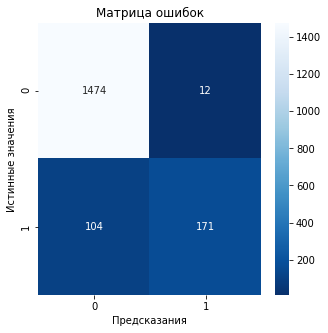

In [141]:
y_pred_2 = cat_grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок');

In [142]:
feature_list = cat_grid.best_estimator_[:-1].get_feature_names_out()
importances =cat_grid.best_estimator_[-1].feature_importances_

In [143]:
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = True).reset_index(drop=True)
feature_results.set_index('feature', inplace=True)
feature_results.head(10)

,importance
feature,
ord__senior_citizen,0.890955
ord__online_security,0.923289
ord__paperless_billing,1.127117
ord__streaming_tv,1.266441
ord__streaming_movies,1.313031
ord__dependents,1.378071
ord__online_backup,1.709386
ord__device_protection,1.720496
ord__multiple_lines,2.392921


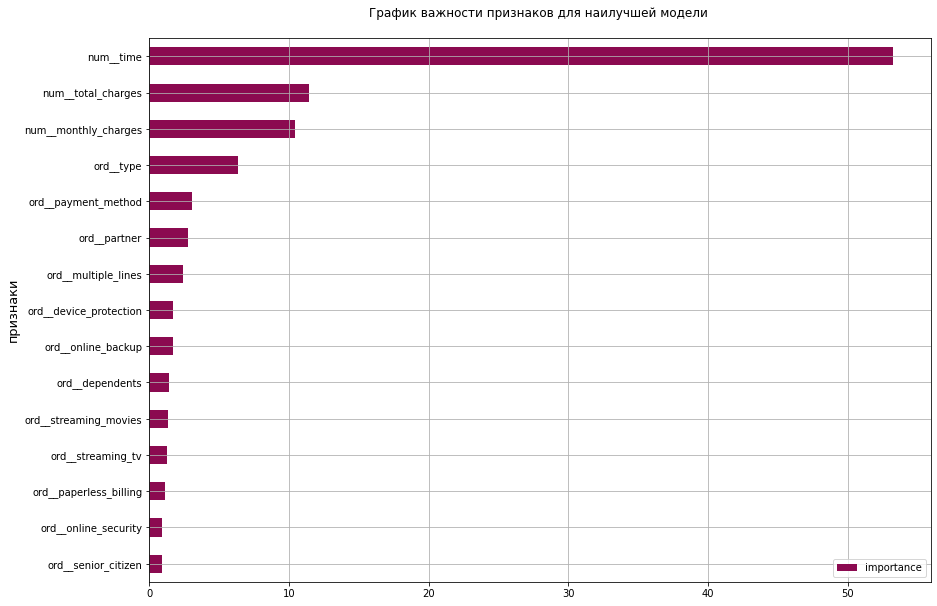

In [144]:
feature_results.plot(kind = 'barh', color = '#8B0A50', figsize=(14, 10));
plt.grid(True)
plt.title(f'График важности признаков для наилучшей модели \n')
plt.ylabel('признаки', fontsize=13);  

### ВЫВОД:

Показатель ROC-AUC лучшей модели на тестовой выборке - 0.931, что больше 0.850(модель корректная).

Была построена ROC-кривая, на графике кривая резко поднимается вверх в левой части графика. Это указывает на то,что модель хорошо распознает наиболее вероятные положительные примеры (клиентоы, которые отказались от оператора).

Также была простроена матрица ошибок:
- истинно положительный (TP) - 1474
- истинно отрицательный (TN) - 171
- ложноположительный результат (FP), ошибка I рода - 12
- ложноотрицательный результат (FN), ошибка II рода 104

Матрица оштбок лучшей модели показала, что ложноотрицательных результатов (клиенты, которые ушли, но модель решила, что они остались), значительно больше, чем ложноположительных результатов.Для модели важны значения ложнопотрицательных значений, их понижение, это может быть достгнуто путем установления порога.

Был проведен анализ важности признаков наилучшей модели. 

Лучшие показатели для модели: 
- time, 
- total_charges, 
- monthly_changes, 
- type.  

Худшие признаки для модели:
- paperless_billing
- online_security
- senior_citizen

По графику видно, самые влиятельные признаки - это количествые, time оказывает самое сильно влияние на тардет. Категорические признаки влияют не так сильно и необходимо либо их доработать либо добавить новые, которые будут лучше простраивать связь с таргетом.


## ШАГ. ИТОГОВЫЙ ВЫВОД

**Цель проекта** состаяла в создании модели, которая будет предстказывать разорвет ли клиент договор или нет.

Для создания данной модели необходимо было решить ряд задач. Далее будут проведены выводы по каждой из задачи.

**ШАГ 1. ЗАГРУЗКА ДАННЫХ.**
На данном шаге была проведена загрузка данных и первичный их осмотр.

**ШАГ 2. ПРЕДОБРАБОТКА ДАННЫХ.**

Во всех данных (contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv) была проведена предобработка данных.

Также в contract:

- в данных total_charges на " " была поставлена заглужка 0,поскольку эти клиенты оформились 2020-02-01(данные рассматриваются по отношению к этой дате, поэтому общий расход 0), данные были приведены к типу float
- в данных end_date на "No" была поставлена заглужка "2020-02-01", поскольку даные актуальны до 01.02.2020. Всего клиентов, у которых не истек срок действия контракта составляет 5942.
- в данных end_date на "No" в дальнейшем будет поставлена заглужка "2020-02-01", поскольку даные актуальны до 01.02.2020. Всего клиентов, у которых не истек срок действия контракта составляет 5942. Но это справедливо для данного набора данных, для других данных может быть так, что заглушка будет перекликаться со значениями. Было принято решение поставить заглушку после этапа объединения данных.


**ШАГ 3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ.**

Исследовательский анализ представленных данных показал, что большинством представленных услуг,клиенты из базы не интересуются. "Средний" клиент оператора - это молодой/зрелый человек, холост, без детей, может быть как мужчина, так и женщина. Клиент предпочитает ежемесячную оплату с помощью электронного расчетного листа, оплату проводить через электронные платежи. Средний доход за месяц - 70.3, общий расход - 1343.


**ШАГ 4. ОБЪЕДИНЕНИЕ ДАННЫХ.**

Было проведено объединение всех данных по столбцу customer_id.

Количество строк в объединенной таблице составляет: 7043 (что соотвествует количеству всех пользователей)

Поскольку пропуски наблюдаются в категорических признаках было принято заменить их на 'other' (нет указания почему именно стоит пропуск, может у клиента подключена эта опция, но по каким-то причинам нет отображения)

Был добавлен целевой признак 'user', который будет отвечать, пользуется ли клиент оператором или уже нет. "True" - не пользуется, "False" - является клиентом. Для дальнейшего удобства значение "True"  изменено на "yes", "False" - "no".

Также был введен столбец time, который показывает сколько дней, клиент пользуется оператором. 

**ШАГ 5. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И КОРРЕЛЯЦИОННЫЙ АНАЛИЗ.**

Анализ портрета оставшегося клиента и ушедшего показал, что:
- ушедший клиент - это женатые мужчины
- ушедший клиент предпочитал пользоваться облачным хранилищем, антивирусом, стриминговым телевидением, каталогом каналов и подключением телефона к нескольким линиям, в отличие от оставшегося.
- у ушедшего клиента средний расход за месяц и общий платеж превышал, чем у оставшегося.

Оставшиеся критерии совпадают.

После корреляционного анализа было принято решение об удалении признаков end_date, customer_id begin_date, tech_support,internet_service,gender. Поскольку эти признаки вызывают мультиколлинеарность.

**ШАГ 6. ПОДГОТОВКА ДАННЫХ.**

В ходе подготовки данных к обучению было сделано:
- после проверки на баланс классов было выявлено, что они разбиты 3:1, что свидетельствует о необходимости стратификации данных.
- данные были разделены на тренировочную и тестовую, также была проведена проверка разделения и размер матриц.
- в треннировочных и тестовых данных наблюдаются различия по матрицам, при обучении необходимо будет воспользоваться балансом.

**ШАГ 7. ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ.**

Было обучено 3 модели: логистическая регрессия, случайный лес и бустинг. Для каждой архитектуры были подобраны гиперпараметры. Лучшую метрику ROC-AUC = 0.897 на тренировочной модели показал CatBoostClassifier.
Ниже приведена таблица с моделями их параметрами и метриками:

**ШАГ 8. ВЫБОР ЛУЧШЕЙ МОДЕЛИ.**

Показатель ROC-AUC лучшей модели на тестовой выборке - 0.928, что больше 0.850(модель корректная).

Была построена ROC-кривая, на графике кривая резко поднимается вверх в левой части графика. Это указывает на то,что модель хорошо распознает наиболее вероятные положительные примеры (клиентоы, которые отказались от оператора).

Также была простроена матрица ошибок:
- истинно положительный (TP) - 1472
- истинно отрицательный (TN) - 167
- ложноположительный результат (FP), ошибка I рода - 14
- ложноотрицательный результат (FN), ошибка II рода 108

Матрица оштбок лучшей модели показала, что ложноотрицательных результатов (клиенты, которые ушли, но модель решила, что они остались), значительно больше, чем ложноположительных результатов.Для модели важны значения ложнопотрицательных значений, их понижение, это может быть достгнуто путем установления порога.

Был проведен анализ важности признаков наилучшей модели. 

Лучшие показатели для модели: 
- time, 
- total_charges, 
- monthly_changes, 
- type.  

Худшие признаки для модели:
- paperless_billing
- online_security
- senior_citizen

По графику видно, самые влиятельные признаки - это количествые, time оказывает самое сильно влияние на тардет. Категорические признаки влияют не так сильно и необходимо либо их доработать либо добавить новые, которые будут лучше простраивать связь с таргетом.

**РЕКОМЕНДАЦИИ** 
1. Установление порога для уменьшения ложноотрицательных значений.
2. Введение новых категорических признаков, от которых таргет будет зависеть лучше.